In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import spearmanr
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, log_loss,\
classification_report, roc_curve, confusion_matrix
from sklearn.dummy import DummyClassifier

from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

import random
from tqdm import tqdm
import joblib

In [14]:
RND_STATE = 777

In [15]:
datasets_names = ["Тренировочный", "Валидационный", "Контрольный"]
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col=0)
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col=0)
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col=0)

datasets = [train, valid, test]

На данном этапе нам необходимо подготовить данные для обучения модели логистической регрессии. Для этого нам необходимо провести следующие операции: 

* Предварительно можно создать дополнительные фичи

1) приведем количественные признаки к нормальному распределению; 

2) выполним масштабирование количественных данных; 

3) применим кодировщик для категориальных данных;

4) отберем признаки (уменьшим размерность).

# Нормализация распределения количественных переменных

В отличие от линейной регрессии, логистическая регрессия не полагается на предположение о нормальном распределении. Однако, решение может стать более стабильным, если распределение предикторов будет многомерным нормальным.

Для этого можно применить преобразование Бокса-Кокса для количественных столбцов.

Однако, стоит помнить, что **$\lambda$ берется с обучающих данных и с ее помощью преобразуются тестовые и контрольные данные**.

In [16]:
quant_cols = train.dtypes[(train.dtypes == int) | (train.dtypes == float)].index

Преобразование Бокса-Кокса требует от данных положительного знака.
$$y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$$

$$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda - 1}{\lambda};\text{если } \lambda \neq 0,\\ \log{(y_i)}; \text{если } \lambda = 0.\end{cases}$$ 
Можно посмотреть, в каких предикторах у нас имеются отрицательные значения.

In [17]:
(train[quant_cols] <= 0).sum()

age                          0
credit_sum                   0
score_shk                    2
monthly_income               0
credit_count             24494
overdue_credit_count    114365
month_payment                0
payment_income_part          0
dtype: int64

In [18]:
for col in ['score_shk', 'credit_count', 'overdue_credit_count']:
    print(f'{col} {train[train[col] <= 0][col].unique()}')

score_shk [0.]
credit_count [ 0. -1.]
overdue_credit_count [ 0. -1.]


Таким образом, в колонке `score_shk` у нас присутствует одно значение равное 0, в колонках `credit_count` и `overdue_credit_count` есть два значения, 0 - нет кредитов данной категории, а -1 означает, что нет информации по данной переменной. Можно прибавить к данным колонкам 0.0001 и 1.0001 соответственно.

Также можно добавить колонки, отражающие наличие пропусков в `credit_count` и `overdue_credit_count`, далее мы все равно проведем дамми-кодирование новых переменных.

In [19]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col + '_na'] = np.where((df[col] == -1), 1, 0).astype('object')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.08it/s]


In [20]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col] = df[col] + 1.0001
        
for df in datasets:
    df['score_shk'] = df['score_shk'] + 0.0001

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.50it/s]


In [21]:
(train[quant_cols] <= 0).sum()
# Теперь у нас нет отрицательных и нулевых значений

age                     0
credit_sum              0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
month_payment           0
payment_income_part     0
dtype: int64

In [22]:
quant_cols =['age', 'credit_sum', 'monthly_income',
             'credit_count', 'overdue_credit_count', 'score_shk',
             'month_payment', 'payment_income_part']

Lambda for age: -0.318


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum: 0.038


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income: -0.146


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_count: 0.520


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for overdue_credit_count: 0.935


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for score_shk: 0.644


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for month_payment: -0.068


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for payment_income_part: 0.148


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


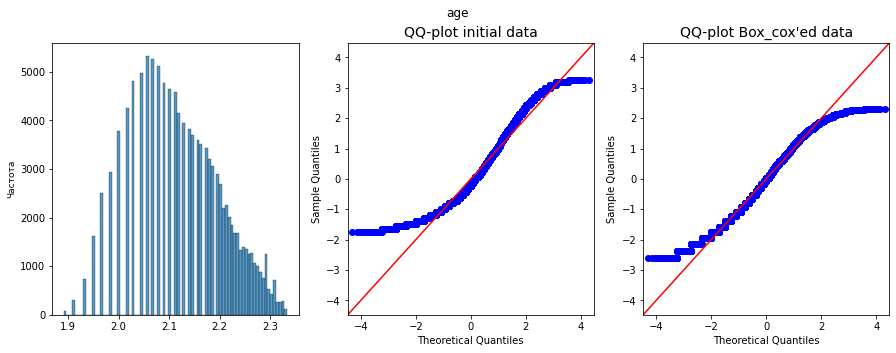

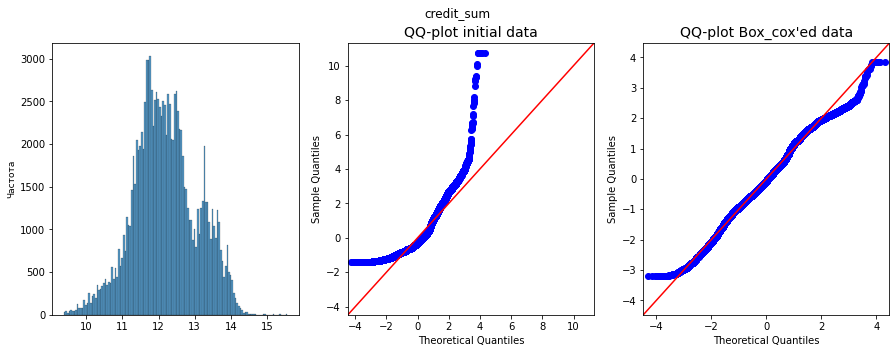

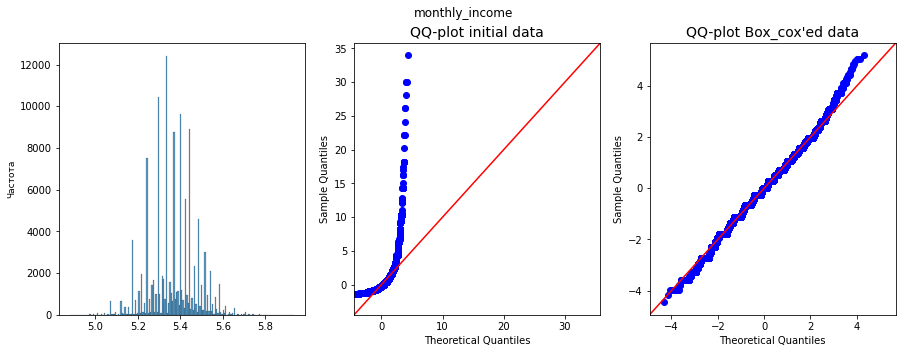

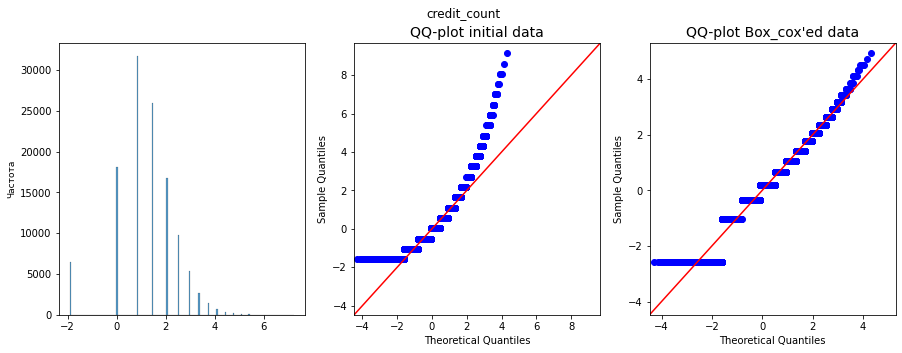

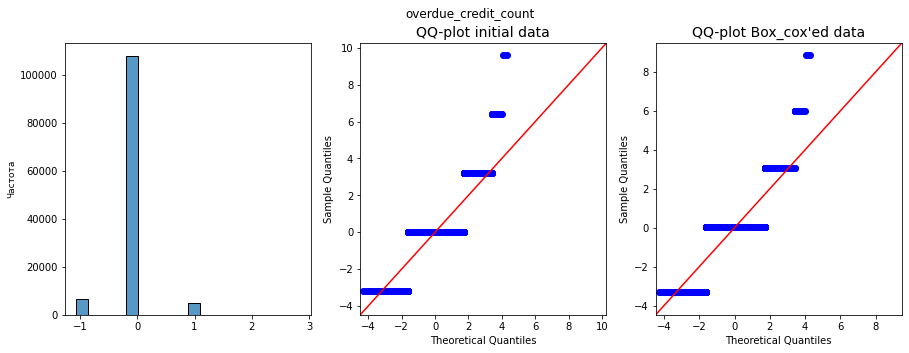

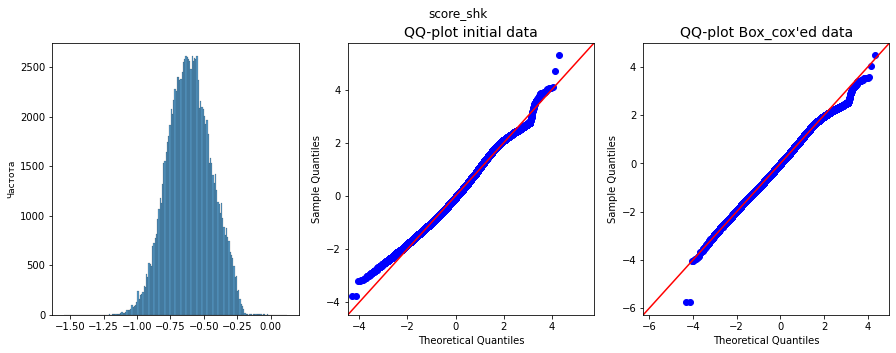

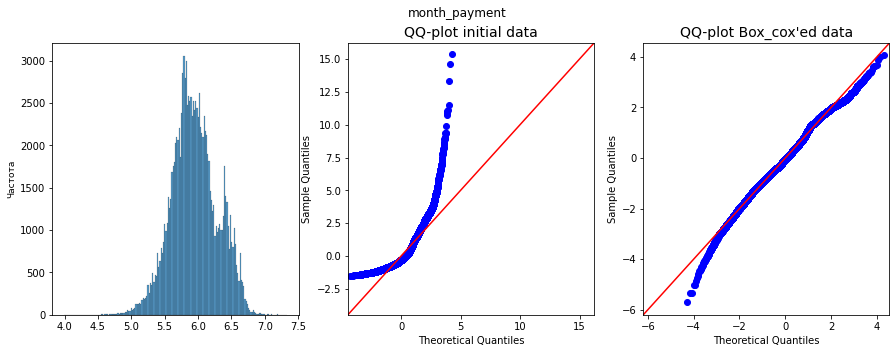

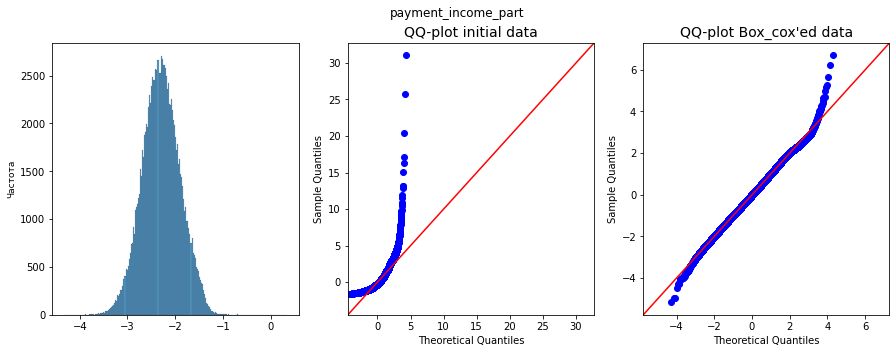

In [23]:
for col in quant_cols:
    transformed, lam = boxcox(train[col])
    print(f'Lambda for {col}: {lam:.3f}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(transformed, ax=ax[0])
    qqplot(train[col], norm, fit=True, line='45', ax=ax[1])
    qqplot(transformed, norm, fit=True, line='45', ax=ax[2])

    ax[0].set_ylabel('Частота', fontsize=9)
    ax[1].set_title("QQ-plot initial data", fontsize=14)
    ax[2].set_title("QQ-plot Box_cox'ed data", fontsize=14)
    fig.suptitle(col)

Можно заметить, что преобразование Бокса-Кокса не обязательно для `credit_count`, `overdue_credit_count`, `score_shk`, поскольку не приводит к значимому улучшению вида распределения переменной. Таким образом, нам надо преобразовать колонки `age`, `credit_sum`, `monthly_income`. Во избежание нулевых значений в тестовом и контрольных наборах до преобразования прибавим к ним 0.0001.

In [24]:
transformation_lambdas = {}
for col in tqdm(quant_cols):
    for ind, df in enumerate(datasets):
        df[col] = df[col] + 0.0001
        if ind == 0: # Поскольку у нас тренировочный датасет первый в списке
            df[col], lam = boxcox(df[col])    
            transformation_lambdas[col] = lam
        else:
            df[col]= boxcox(df[col], lam)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.72it/s]


In [25]:
transformation_lambdas

{'age': -0.3178831313449778,
 'credit_sum': 0.03838551579008124,
 'monthly_income': -0.14564076859225772,
 'credit_count': 0.5298297530853822,
 'overdue_credit_count': 0.9570711126311593,
 'score_shk': 0.6436609437954757,
 'month_payment': -0.06819472893275555,
 'payment_income_part': 0.14570054875925367}

In [26]:
train['monthly_income']

87470     5.285763
77449     5.295132
97073     5.336300
6498      5.336300
156564    5.513909
            ...   
83528     5.320850
138673    5.151297
141915    5.385221
35227     5.370265
125619    5.539954
Name: monthly_income, Length: 119522, dtype: float64

Проведем кодирование категориальных переменных по методу "с одним активным состоянием".

In [27]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

In [28]:
train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [29]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [30]:
scaler = RobustScaler()
scaler.fit(X_train)

X_tr_scaled = pd.DataFrame(scaler.transform(X_train.values),
                           columns=X_train.columns,
                           index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_valid.values),
                            columns=X_valid.columns,
                            index=X_valid.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X_test.columns,
                             index=X_test.index)

In [31]:
lr_metrics = pd.DataFrame(index=['roc-auc', 'precision',
                                 'recall', 'f1', 'logloss'])

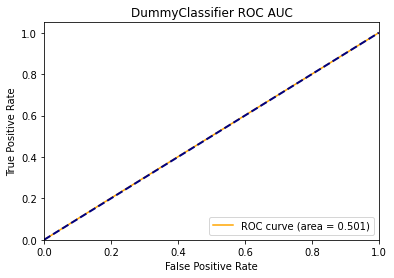

In [32]:
dummy = DummyClassifier(strategy='stratified', random_state=RND_STATE)
dummy.fit(X_tr_scaled, y_train)

y_pred = dummy.predict(X_val_scaled)
y_score = dummy.predict_proba(X_val_scaled)[:,1]
    
lr_metrics['DummyClassifier'] = [roc_auc_score(y_valid, y_score),
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('DummyClassifier ROC AUC')
plt.legend(loc="lower right")
plt.show()

In [33]:
lr_metrics

,DummyClassifier
roc-auc,0.500769
precision,0.177318
recall,0.173150
f1,0.175209
logloss,9.910890


# Baseline-модель

In [34]:
def make_log_reg(x_train, y_train, x_valid, y_valid,
                 results_df, model_name, parameters={'max_iter':1500}):  
    log_reg_model =  LogisticRegression(**parameters,
                                        class_weight = 'balanced',
                                        random_state=RND_STATE)
    log_reg_model.fit(x_train, y_train)
    
    y_pred = log_reg_model.predict(x_valid)
    y_score = log_reg_model.predict_proba(x_valid)[:,1]
    
    results_df[model_name] = [roc_auc_score(y_valid, y_score),
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
    fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

    plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Logistic Regression ROC AUC')
    plt.legend(loc="lower right")
    plt.show()
    return log_reg_model

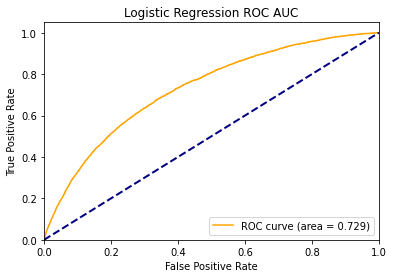

In [35]:
lr_baseline = make_log_reg(x_train=X_tr_scaled,
                           y_train=y_train,
                           x_valid=X_val_scaled,
                           y_valid=y_valid,
                           results_df=lr_metrics,
                           model_name='lr_baseline')

In [36]:
lr_metrics

,DummyClassifier,lr_baseline
roc-auc,0.500769,0.729256
precision,0.177318,0.308196
recall,0.173150,0.646085
f1,0.175209,0.417322
logloss,9.910890,10.968681


# Подбор оптимальных гиперпараметров

In [37]:
def find_optimal_params(x_train, y_train, parameters_grid,
                        cv_n_splits=5, n_jobs=-1):
    lr_basic_params = {
        'class_weight':'balanced',
        'random_state':RND_STATE
    }
    
    log_reg = LogisticRegression(**lr_basic_params)
    strat_cv = StratifiedKFold(n_splits=cv_n_splits,
                               shuffle=True)
    
    grid_cv = GridSearchCV(log_reg,
                           parameters_grid,
                           scoring='roc_auc',
                           cv=strat_cv,
                           verbose=10,
                           n_jobs=n_jobs)   
    
    grid_cv.fit(x_train, y_train)
    print(f'Наилучший ROC AUC = {grid_cv.best_score_:.4f}')
    print(f'Наилучшие параметры: {grid_cv.best_params_}')
    return grid_cv

In [38]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(0.1, 1000, num=5),
    'solver': ['sag', 'liblinear', 'lbfgs'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(400, 2000, 200)
}

In [39]:
!telegram-send "grid_baseline_cv optimization started!"

In [40]:
%%time
grid_baseline_cv = find_optimal_params(x_train=X_tr_scaled,
                                       y_train=y_train,
                                       parameters_grid=parameters_grid)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


One or more of the test scores are non-finite: [       nan 0.73067374        nan ...        nan        nan        nan]
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Наилучший ROC AUC = 0.7316
Наилучшие параметры: {'C': 1000.0, 'l1_ratio': 0.2, 'max_iter': 800, 'penalty': 'l2', 'solver': 'lbfgs'}
Wall time: 7h 45min 6s


In [41]:
!telegram-send "grid_baseline_cv optimized!"

Traceback (most recent call last):
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3\connection.py", line 140, in _new_conn
    conn = connection.create_connection(
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3\util\connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\program files\python39\lib\socket.py", line 953, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3\connectionpool.py", line 614, in urlopen
    httplib_response = self._make_request(conn, method, url,
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3

In [42]:
baseline_best_params = grid_baseline_cv.best_params_

In [45]:
# baseline_best_params = {'C': 1000.0,
#                         'l1_ratio': 0.2,
#                         'max_iter': 800,
#                         'penalty': 'l2',
#                         'solver': 'lbfgs'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


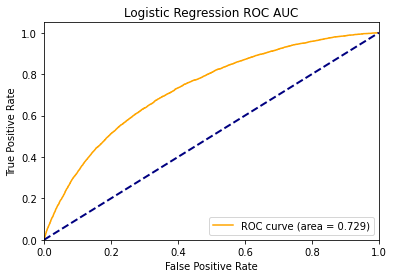

In [46]:
lr_baseline_tuned = make_log_reg(x_train=X_tr_scaled,
                                 y_train=y_train,
                                 x_valid=X_val_scaled,
                                 y_valid=y_valid,
                                 results_df=lr_metrics,
                                 parameters=baseline_best_params,
                                 model_name='lr_baseline_tuned')

In [47]:
lr_metrics[:-1].style.highlight_max(axis=1, color='lightblue')

,DummyClassifier,lr_baseline,lr_baseline_tuned
roc-auc,0.500769,0.729256,0.729326
precision,0.177318,0.308196,0.308543
recall,0.173150,0.646085,0.646251
f1,0.175209,0.417322,0.417674


Можно заметить, что производительность модели возрасла лишь слегка, что, возможно, связано с предупреждениями, которые мы получили в ходе обучения модели. Проверим первое предположение со StackOverflow о различии колонок в датасетах.

Мы получили следующее предупреждение:

*warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\глеб\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite*

На StackOverflow есть несколько мыслей по этому поводу:
1. [В проверочном и обучающем наборе есть различия в категориях, поэтому когда на проверочном датасете появляется категория, которая отсутствует в обучающем наборе, то логистическая регрессия выдает NaN.](https://stackoverflow.com/questions/66620269/i-got-the-warning-userwarning-one-or-more-of-the-test-scores-are-non-finite-w)
2. [Второе решение возможно, кроется в комбинации гиперпараметров, которые могут приводить к NaN-значениям.](https://stackoverflow.com/questions/67535904/userwarning-one-or-more-of-the-test-scores-are-non-finite-warning-only-when-a)

В первом случае необходимо проверить, что предикторы во всех наборах одинаковы, а во втором посмотреть в `grid_cv.cv_results_` сочетания гиперпараметров, которые приводят к неопределенным значениям.

Однако, для начала, можно посмотреть на показатели качества полученной с предупреждениями модели.

In [48]:
print((X_valid.columns == X_train.columns).all())
print((X_test.columns == X_train.columns).all())

True
True


Таким образом, видно, что проблема не в различных категориях.

Тогда проверим кроется ли проблема в сочетаниях гиперпараметров.

In [51]:
grid_results = pd.DataFrame(grid_baseline_cv.cv_results_)
bad_grid_results = grid_results[grid_results['split0_test_score'].isna()]

In [52]:
bad_grid_results['param_solver'].unique()
# Проблемы есть только с 'sag', 'lbfgs'

array(['sag', 'lbfgs', 'liblinear'], dtype=object)

In [53]:
bad_grid_results[bad_grid_results['param_solver'] == 'sag'].head(6)
# Видим, что оптимизатор sag работет только с регуляризацией l2 - лассо.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.272283,0.021751,0.0,0.0,0.1,0.2,400,l1,sag,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,708
6,0.355052,0.009120,0.0,0.0,0.1,0.2,400,elasticnet,sag,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1089
9,0.334295,0.007653,0.0,0.0,0.1,0.2,600,l1,sag,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1092
15,0.311448,0.008415,0.0,0.0,0.1,0.2,600,elasticnet,sag,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094
18,0.346794,0.006249,0.0,0.0,0.1,0.2,800,l1,sag,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1097
24,0.318347,0.015423,0.0,0.0,0.1,0.2,800,elasticnet,sag,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1099


In [54]:
bad_grid_results[bad_grid_results['param_solver'] == 'lbfgs'].head(6)
# Видим, что оптимизатор lbfgs работет только с регуляризацией l2 - лассо.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.303024,0.027707,0.0,0.0,0.1,0.2,400,l1,lbfgs,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1088
8,0.361822,0.025066,0.0,0.0,0.1,0.2,400,elasticnet,lbfgs,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1091
11,0.336501,0.023259,0.0,0.0,0.1,0.2,600,l1,lbfgs,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1093
17,0.340545,0.020722,0.0,0.0,0.1,0.2,600,elasticnet,lbfgs,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1096
20,0.380574,0.036314,0.0,0.0,0.1,0.2,800,l1,lbfgs,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1098
26,0.375795,0.025147,0.0,0.0,0.1,0.2,800,elasticnet,lbfgs,"{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1102


In [55]:
bad_grid_results['mean_score_time'].mean()

0.0

Мы также могли прийти к таким же выводам посмотрев предупреждения в ходе поиска по сетке:

*ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.*

Однако, если посмотреть на среднее время вычислений при таких комбинациях, то оно равно 0, т.е. мы не теряем в производительности поиска оптимальных гиперпараметров.

Таким образом, оптимиизация гиперпараметров не дала ощутимых результатов, следовательно, улучшение модели можно провести путем создания различных переменных, которые должны внести нелинейные взаимодействия в модель логистической регрессии.

# Добавление новых предикторов

In [56]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

datasets = [train, valid, test]

In [57]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col + '_na'] = np.where((df[col] == -1), 1, 0).astype('object')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.53it/s]


In [58]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col] = df[col] + 1.0001
        
for df in datasets:
    df['score_shk'] = df['score_shk'] + 0.0001

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 401.37it/s]


Теперь создадим переменные - средние значения количественной переменной, взятые по уровню категориальной переменной. А также сравним показатель клиента с этим средним значением. 

Например, колонка `score_is_gt_median_education` отображает превосходит ли внутренняя скоринговая оценка клиента медианное значение для людей с таким же образованием.

In [59]:
categorical_cols = ['living_region', 'gender',
                    'marital_status', 'job_position',
                    'education']

quantitative_cols = ['age', 'credit_sum', 'credit_month',
                     'score_shk', 'monthly_income',
                     'credit_count', 'overdue_credit_count']

category_col_names = dict(zip(categorical_cols, ['region', 'gender',
                                                 'marital', 'job', 'education']))

quantitative_col_names = dict(zip(quantitative_cols, ['age','cr_sum', 'cr_month',
                                                      'score', 'income', 'cr_count',
                                                      'overdue_count']))

for category in tqdm(categorical_cols):
    for indicator in quantitative_cols:
        grouped = train.groupby(category)[indicator].agg(np.median).to_dict()
        median_col_name = category_col_names[category] + '_median_' +  quantitative_col_names[indicator]
        is_gt_median_col_name = quantitative_col_names[indicator] + '_is_gt_median_' + category_col_names[category]             
        for df in datasets:
            df[median_col_name] = df[category].map(grouped)                      
            df[is_gt_median_col_name] = np.where(df[indicator] >= df[median_col_name], '1', '0')
            df.drop(median_col_name, axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.25it/s]


In [60]:
for indicator in tqdm(quantitative_cols):
    for df in datasets:
        df[indicator + '_sq'] = df[indicator] ** 2
        df[indicator + '_inv'] = (1 / df[indicator]).replace([np.inf, -np.inf], -1)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 219.34it/s]


In [61]:
quantitative_cols = ['age', 'credit_sum', 'monthly_income',
                     'month_payment', 'payment_income_part'] + list(train.columns)[-14:]

Lambda for age: -0.318


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum: 0.038


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income: -0.146


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for month_payment: -0.068


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for payment_income_part: 0.148


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for age_sq: -0.159


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for age_inv: 0.318


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum_sq: 0.019


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum_inv: -0.038


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_month_sq: 0.037


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_month_inv: -0.074


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for score_shk_sq: 0.322


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for score_shk_inv: -0.644


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income_sq: -0.073


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income_inv: 0.146


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_count_sq: 0.260


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_count_inv: -0.520


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for overdue_credit_count_sq: 0.467
Lambda for overdue_credit_count_inv: -0.935


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


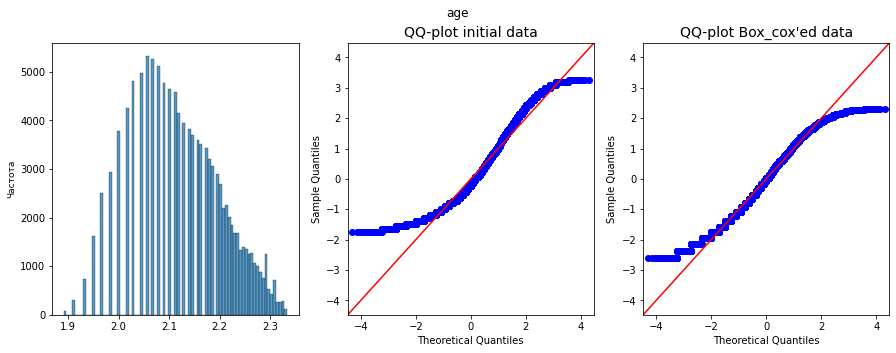

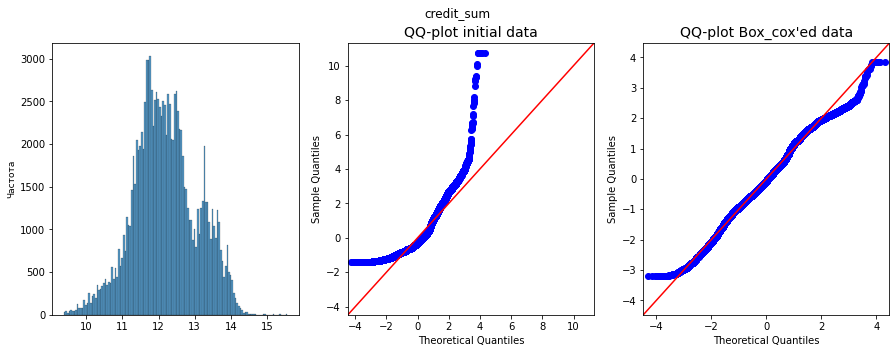

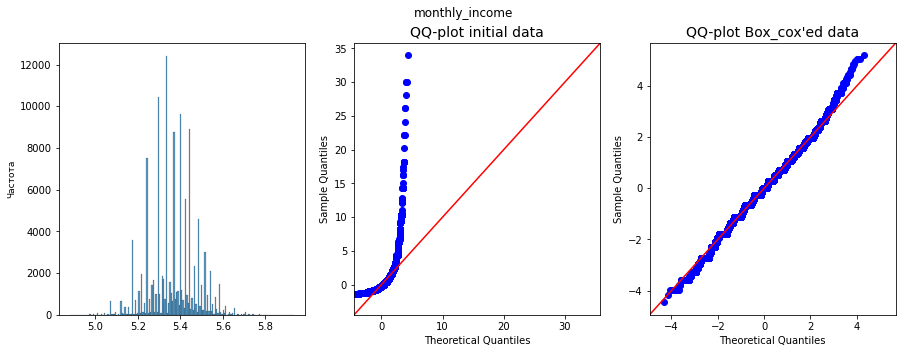

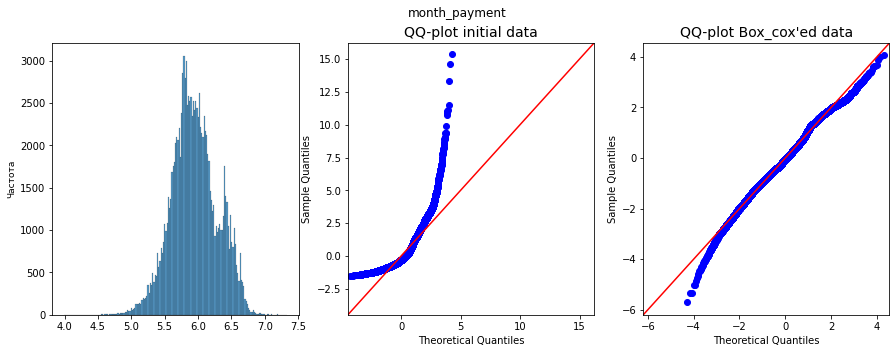

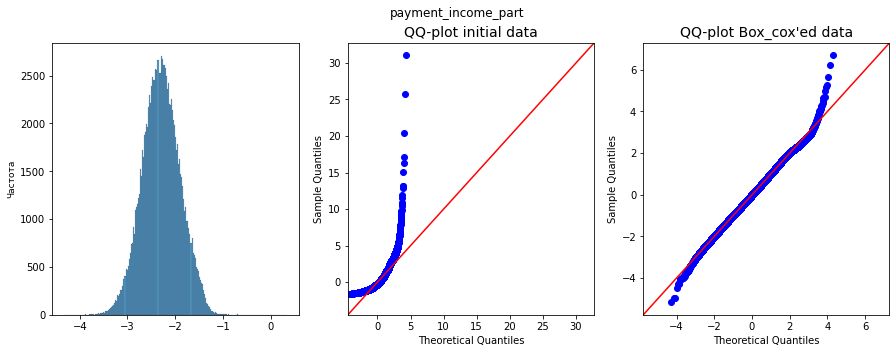

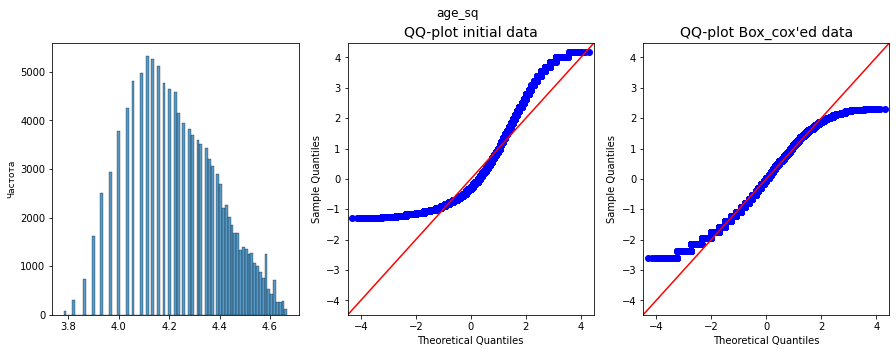

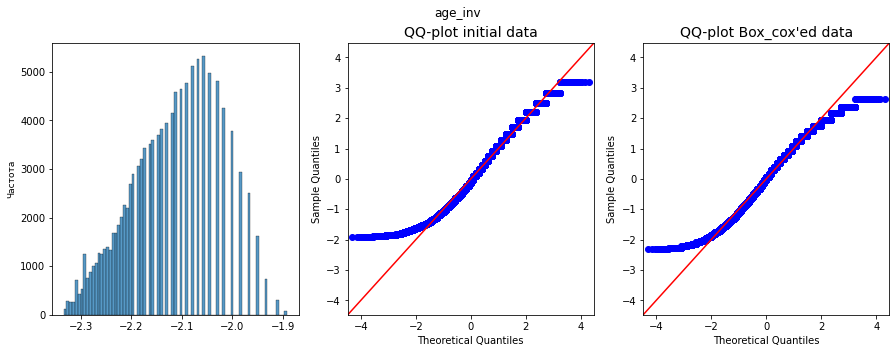

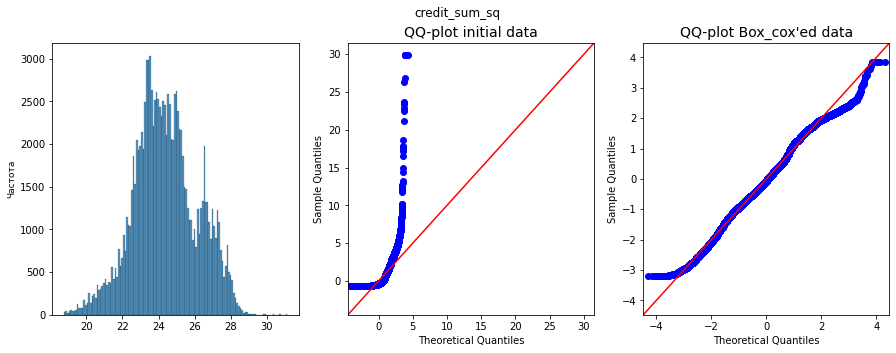

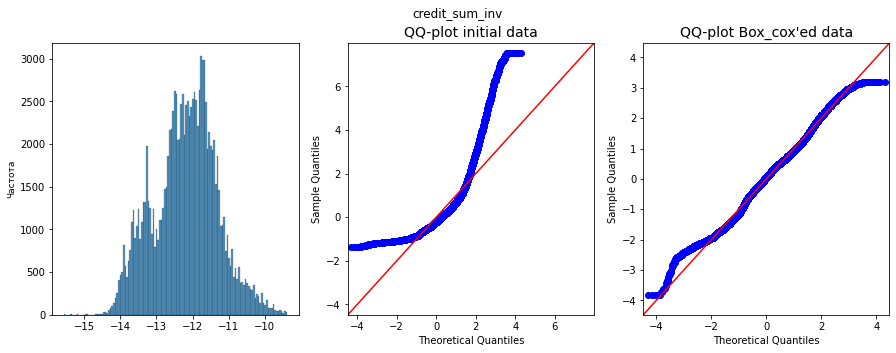

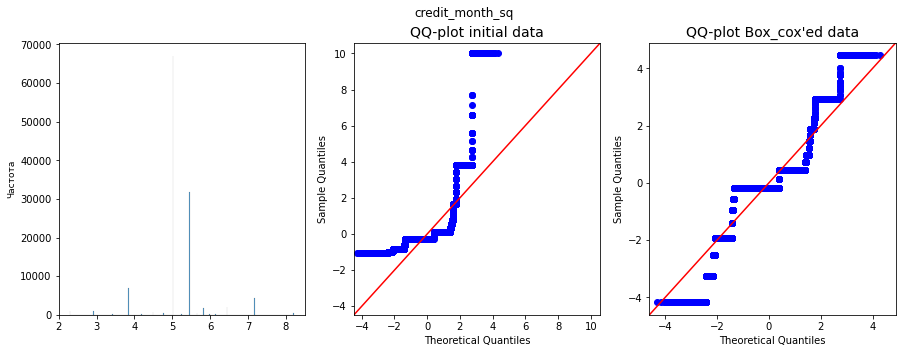

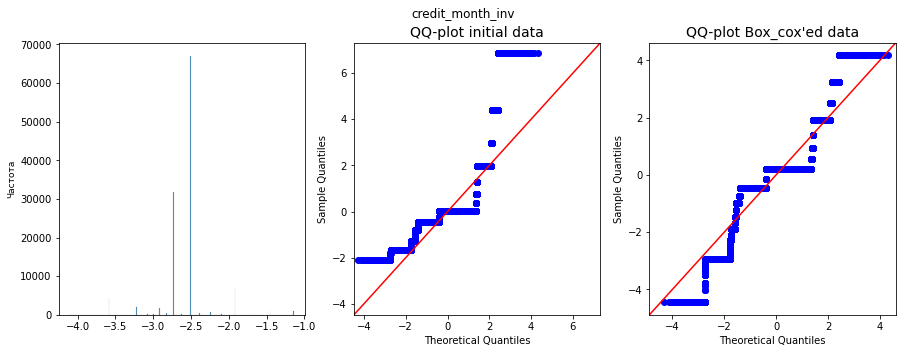

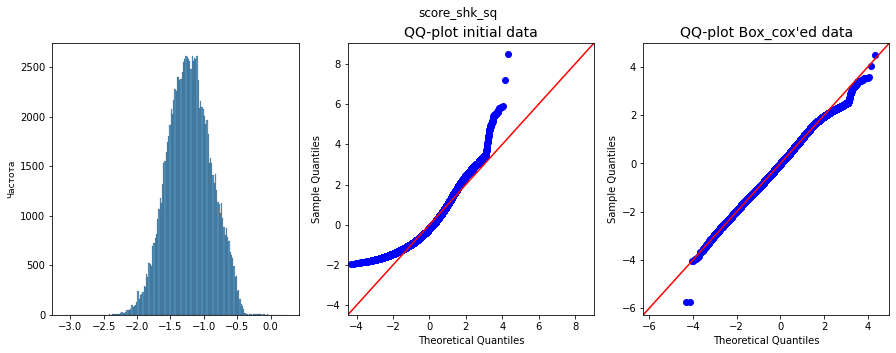

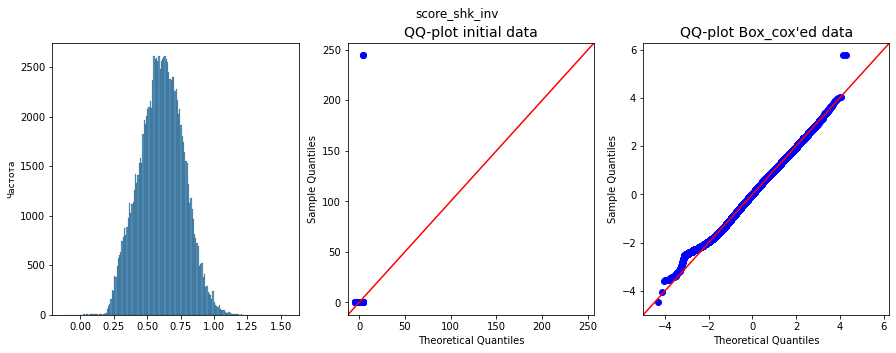

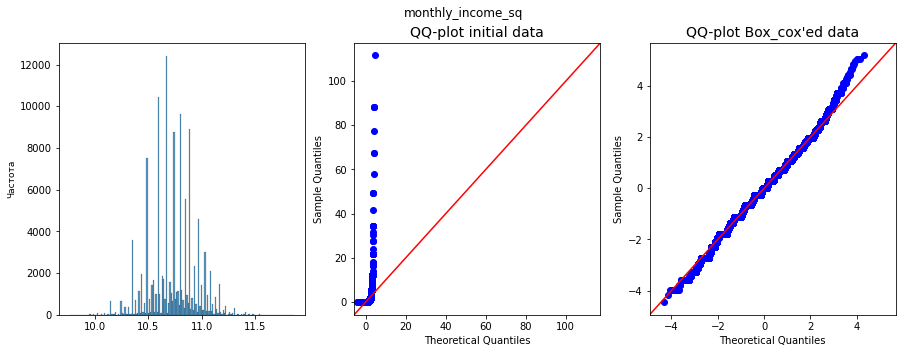

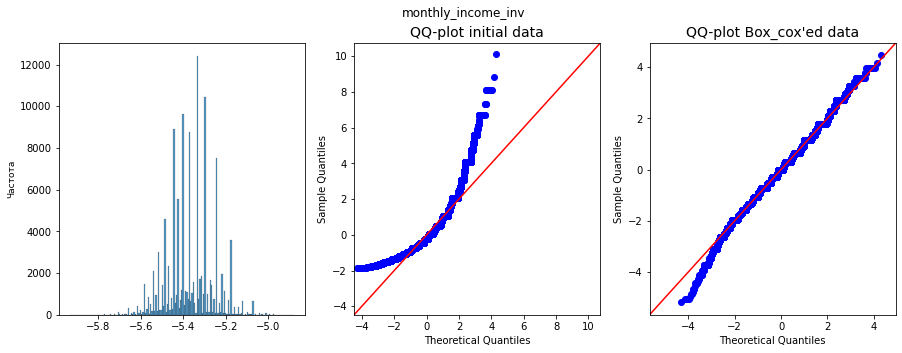

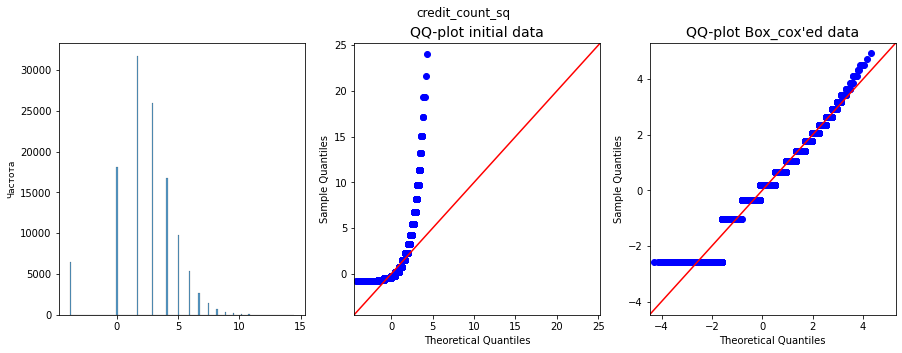

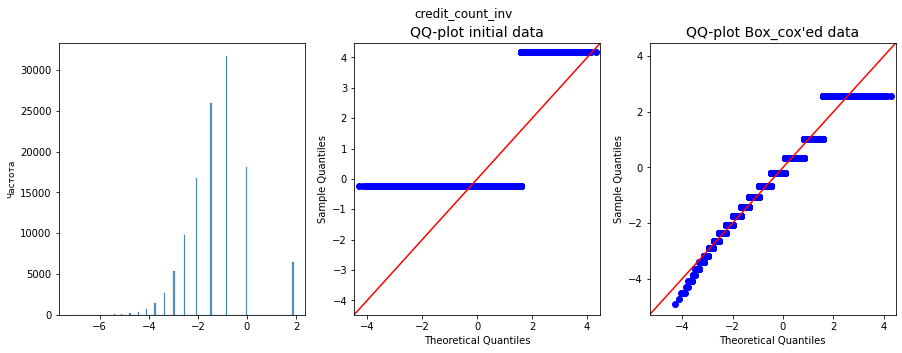

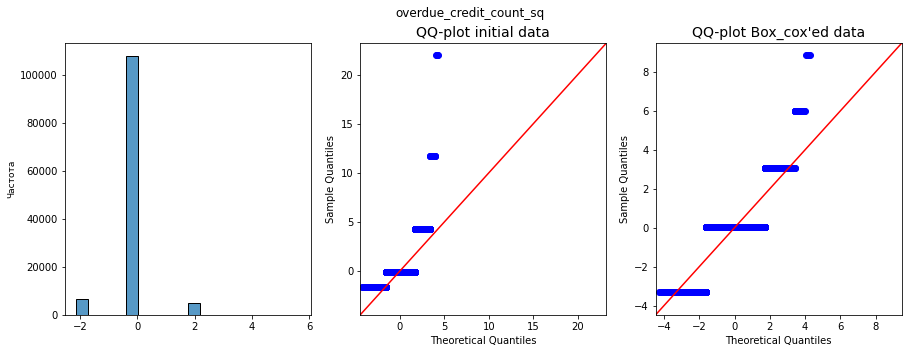

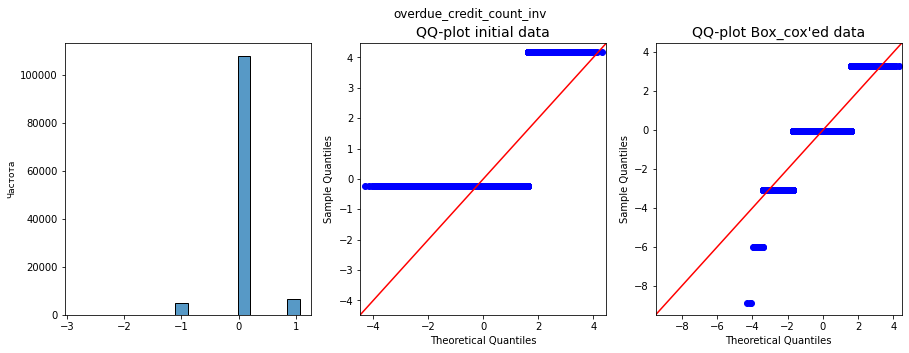

In [62]:
for col in quantitative_cols:
    transformed, lam = boxcox(train[col])
    print(f'Lambda for {col}: {lam:.3f}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(transformed, ax=ax[0])
    qqplot(train[col], norm, fit=True, line='45', ax=ax[1])
    qqplot(transformed, norm, fit=True, line='45', ax=ax[2])

    ax[0].set_ylabel('Частота', fontsize=9)
    ax[1].set_title("QQ-plot initial data", fontsize=14)
    ax[2].set_title("QQ-plot Box_cox'ed data", fontsize=14)
    fig.suptitle(col)

In [63]:
boxcox_cols = ['age','credit_sum',
              'monthly_income', 'month_payment',
              'payment_income_part', 'age_sq',
              'age_inv', 'credit_sum_sq',
              'credit_sum_inv', 'credit_month_sq',
              'credit_month_inv', 'score_shk_sq',
              'score_shk_inv', 'monthly_income_sq',
              'monthly_income_inv', 'credit_count_inv',
              'overdue_credit_count_inv']

In [64]:
transformation_lambdas_wcols = {}
for col in tqdm(boxcox_cols):
    for ind, df in enumerate(datasets):
        df[col] = df[col] + 0.0001
        if ind == 0:
# Поскольку у нас тренировочный датасет первый в списке
            df[col], lam = boxcox(df[col])    
            transformation_lambdas_wcols[col] = lam
        else:
            df[col]= boxcox(df[col], transformation_lambdas_wcols[col])

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.21it/s]


In [65]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

In [66]:
train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Baseline-модель с новыми предикторами

In [67]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [68]:
scaler = RobustScaler()
scaler.fit(X_train)

X_tr_scaled_wcols = pd.DataFrame(scaler.transform(X_train.values),
                                 columns=X_train.columns,
                                 index=X_train.index)
X_val_scaled_wcols = pd.DataFrame(scaler.transform(X_valid.values),
                                  columns=X_valid.columns,
                                  index=X_valid.index)
X_test_scaled_wcols = pd.DataFrame(scaler.transform(X_test.values),
                                   columns=X_test.columns,
                                   index=X_test.index)

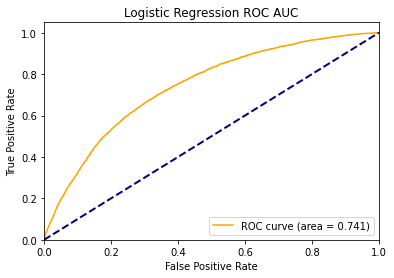

In [69]:
lr_baseline_wcols = make_log_reg(x_train=X_tr_scaled_wcols,
                                 y_train=y_train,
                                 x_valid=X_val_scaled_wcols,
                                 y_valid=y_valid,
                                 results_df=lr_metrics,
                                 model_name='lr_baseline_wcols')

In [70]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,DummyClassifier,lr_baseline,lr_baseline_tuned,lr_baseline_wcols
roc-auc,0.500769,0.729256,0.729326,0.740724
precision,0.177318,0.308196,0.308543,0.320245
recall,0.173150,0.646085,0.646251,0.657507
f1,0.175209,0.417322,0.417674,0.430709
logloss,9.910890,10.968681,10.955598,10.567130


Видим, что добавление новых предикторов позволило значительно увеличить качество модели. Логистическая регрессия хороша тем, что позволяет достаточно просто интерпретировать вклад каждой переменной на исход (таргетную переменную), однако, для этого необходимо устранить корреляцию между предикторами.

##  Попробуем модель, где отсутствует корреляция между переменными

Вследствие корреляции между предсказателями необходимо проявлять осторожность в интерпертации коэффициентов в множественной регрессии. Мультиколлинеарность может вызвать числовую нестабильность в подгонке уравнения регрессии. Таким образом, для корректной интерпертации коэффициентов регрессии нам необходимо избавиться от коррелированных переменных, что также сократит количество предикторов нашей модели - сделает ее проще, что есть хорошо, согласно бритве Оккама.

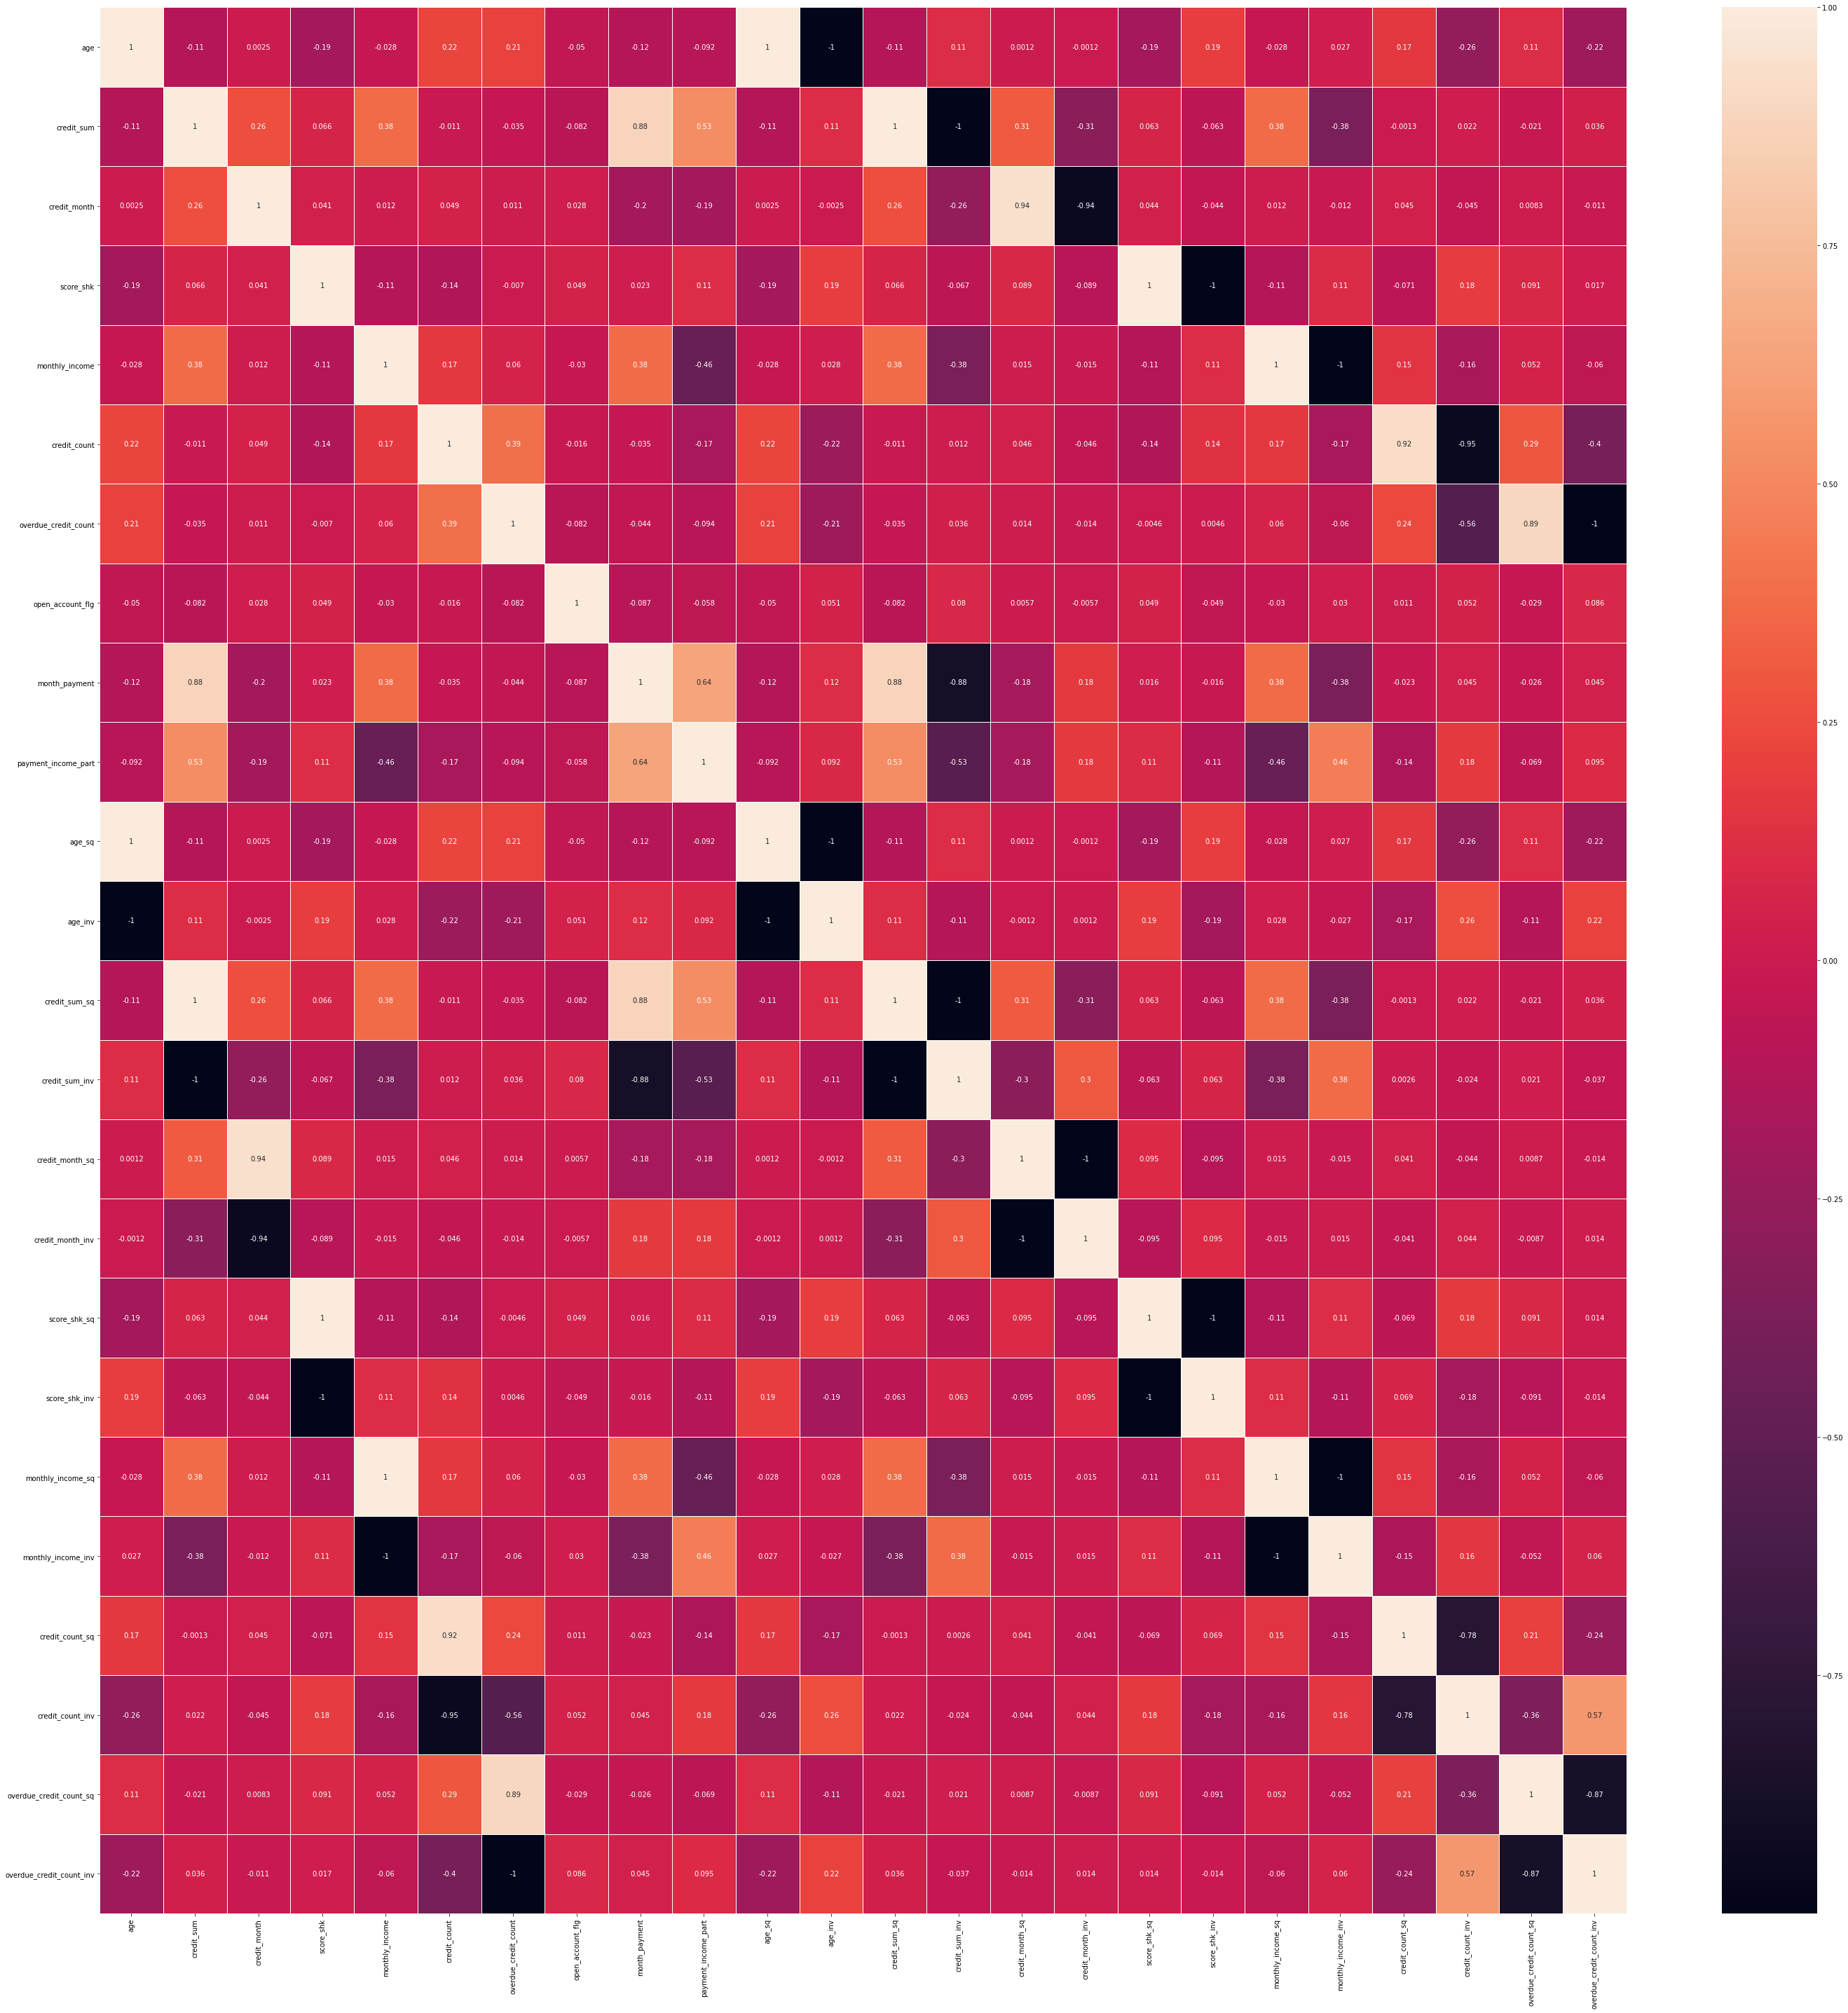

In [71]:
plt.figure(figsize=(40,40))
sns.heatmap(train.corr(method='pearson'), annot=True, linewidths=1)
plt.tight_layout()

Рассмотрим какие переменные имеют какое количество сильных корреляций.

In [72]:
corr_predictors = ((train.corr(method='pearson') > 0.7) |
                   (train.corr(method='pearson') < -0.7)).sum().sort_values(ascending=False)

In [73]:
corr_predictors

credit_sum_sq               4
credit_sum_inv              4
month_payment               4
credit_sum                  4
overdue_credit_count_sq     3
credit_count_inv            3
credit_count_sq             3
monthly_income_inv          3
monthly_income_sq           3
score_shk_inv               3
score_shk_sq                3
credit_month_inv            3
credit_month_sq             3
age                         3
age_inv                     3
age_sq                      3
overdue_credit_count        3
credit_count                3
monthly_income              3
score_shk                   3
credit_month                3
overdue_credit_count_inv    3
payment_income_part         1
open_account_flg            1
dtype: int64

In [74]:
cols_to_drop = corr_predictors[corr_predictors > 3].index
cols_to_drop

Index(['credit_sum_sq', 'credit_sum_inv', 'month_payment', 'credit_sum'], dtype='object')

In [75]:
train_ncorr = train.copy()
valid_ncorr = valid.copy()
test_ncorr = test.copy()    
dfs_ncorr = [train_ncorr, valid_ncorr, test_ncorr]

for df in dfs_ncorr:
    df.drop(cols_to_drop, axis=1, inplace=True)

In [76]:
cat_cols_ncorr = train_ncorr.dtypes[train_ncorr.dtypes == 'object'].index

In [77]:
train_label_ncorr = pd.get_dummies(train_ncorr, columns=cat_cols_ncorr, drop_first=True)
valid_label_ncorr = pd.get_dummies(valid_ncorr, columns=cat_cols_ncorr, drop_first=True)
test_label_ncorr = pd.get_dummies(test_ncorr, columns=cat_cols_ncorr, drop_first=True)

# Baseline-модель с новыми предикторами без корреляции

In [78]:
X_train_ncorr = train_label_ncorr.drop('open_account_flg', axis=1)
y_train_ncorr = train_label_ncorr['open_account_flg']

X_valid_ncorr = valid_label_ncorr.drop('open_account_flg', axis=1)
y_valid_ncorr = valid_label_ncorr['open_account_flg']

X_test_ncorr = test_label_ncorr.drop('open_account_flg', axis=1)
y_test_ncorr = test_label_ncorr['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [79]:
scaler = RobustScaler()
scaler.fit(X_train_ncorr)

X_tr_scaled_ncorr = pd.DataFrame(scaler.transform(X_train_ncorr.values),
                                 columns=X_train_ncorr.columns,
                                 index=X_train_ncorr.index)
X_val_scaled_ncorr = pd.DataFrame(scaler.transform(X_valid_ncorr.values),
                                  columns=X_valid_ncorr.columns,
                                  index=X_valid_ncorr.index)
X_test_scaled_ncorr = pd.DataFrame(scaler.transform(X_test_ncorr.values),
                                   columns=X_test_ncorr.columns,
                                   index=X_test_ncorr.index)

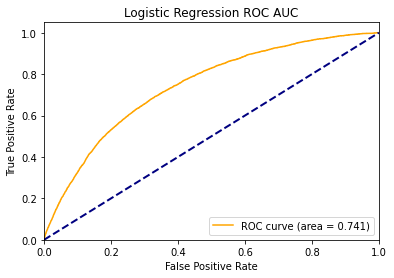

In [80]:
lr_wcols_nocorr = make_log_reg(x_train=X_tr_scaled_ncorr,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_ncorr,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 model_name='lr_wcols_nocorr')

In [81]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,DummyClassifier,lr_baseline,lr_baseline_tuned,lr_baseline_wcols,lr_wcols_nocorr
roc-auc,0.500769,0.729256,0.729326,0.740724,0.740565
precision,0.177318,0.308196,0.308543,0.320245,0.318273
recall,0.173150,0.646085,0.646251,0.657507,0.656514
f1,0.175209,0.417322,0.417674,0.430709,0.428710
logloss,9.910890,10.968681,10.955598,10.567130,10.637577


С увеличением числа предикторов, качество модели улучшилось, однако, недообучение модели может вносить свою лепту, поскольку число итераций осталось прежним. Можно проверить зависимость ROC AUC от числа итераций.

In [82]:
iter_num_results = pd.DataFrame(columns=['roc_auc', 'precision_score',
                                         'recall_score', 'f1_score', 'log_loss'])

iter_num_results_funcs = [precision_score, recall_score, f1_score, log_loss]

In [83]:
for iter_num in tqdm(np.linspace(100, 3000, 30)):
    lr_baseline_wcols = LogisticRegression(class_weight = 'balanced',
                                           max_iter=iter_num,
                                           random_state=RND_STATE)
    lr_baseline_wcols.fit(X_tr_scaled, y_train)

    y_pred = lr_baseline_wcols.predict(X_val_scaled)
    y_score = lr_baseline_wcols.predict_proba(X_val_scaled)[:,1]
    
    iter_num_results.at[iter_num, 'roc_auc'] = roc_auc_score(y_valid, y_score)
    
    for i, col in enumerate(iter_num_results.columns[1:]):
        iter_num_results.at[iter_num, col] = iter_num_results_funcs[i](y_valid, y_pred)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  3%|██▊                                                                                | 1/30 [00:02<01:20,  2.79s/it]lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  7%|█████▌ 

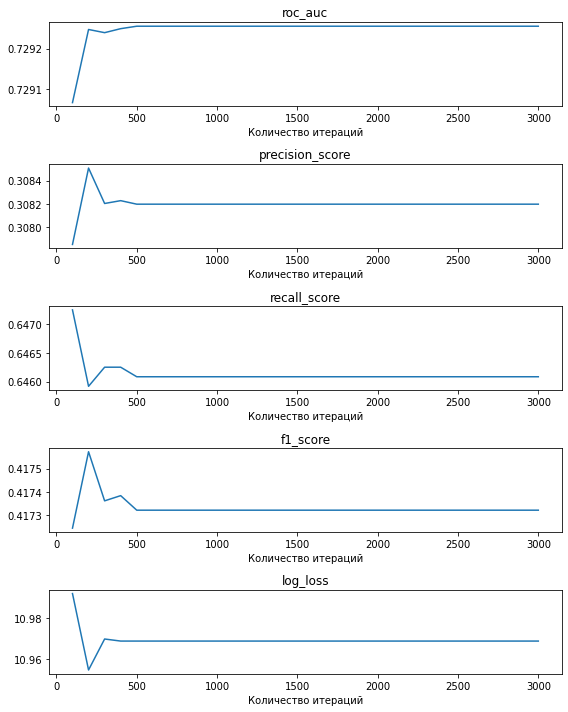

In [84]:
fig, ax = plt.subplots(5,1, figsize=(8,10))
for i, col in enumerate(iter_num_results.columns):
    iter_num_results[col].plot(ax=ax[i])
    ax[i].set_title(col)
    ax[i].set(xlabel='Количество итераций')

fig.tight_layout()

Видно, что при количестве итераций превышающих 1000 улучшение площади под кривой ROC не происходит, следовательно, использование большего количества итераций бессмысленно.

Таким образом, на основании выбранных показателей эффективности, можно заключить, что наилучшая модель - модель, с множеством дополнительных предикторов но без коррелированных переменных. Оптимизируем ее поиском гиперпараметров по сетке.

In [85]:
!telegram-send "grid_cv_wcols_ncorr optimization started!"

In [86]:
%%time
grid_cv_wcols_ncorr = find_optimal_params(x_train=X_tr_scaled_ncorr,
                                          y_train=y_train_ncorr,
                                          parameters_grid=parameters_grid)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


One or more of the test scores are non-finite: [       nan 0.74411493        nan ...        nan        nan        nan]
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Наилучший ROC AUC = 0.7474
Наилучшие параметры: {'C': 1000.0, 'l1_ratio': 0.2, 'max_iter': 400, 'penalty': 'l2', 'solver': 'liblinear'}
Wall time: 1d 11h 32min 50s


In [87]:
!telegram-send "grid_cv_wcols_ncorr optimization is over!"

In [88]:
best_params_wcols_ncorr = grid_cv_wcols_ncorr.best_params_

In [89]:
# best_params_wcols_ncorr = {'C': 500.5, 
#                            'l1_ratio': 0.2,
#                            'max_iter': 4000, 
#                            'penalty': 'l2', 
#                            'solver': 'lbfgs'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


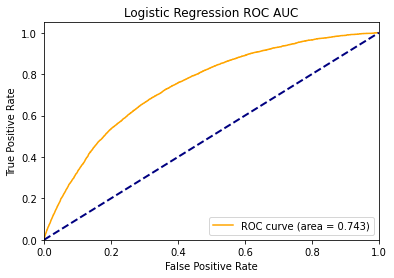

In [90]:
grid_LR_ncorr = make_log_reg(x_train=X_tr_scaled_ncorr,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_ncorr,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 parameters=best_params_wcols_ncorr,
                                 model_name='Grid_LR_ncorr')

In [91]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,DummyClassifier,lr_baseline,lr_baseline_tuned,lr_baseline_wcols,lr_wcols_nocorr,Grid_LR_ncorr
roc-auc,0.500769,0.729256,0.729326,0.740724,0.740565,0.743080
precision,0.177318,0.308196,0.308543,0.320245,0.318273,0.320513
recall,0.173150,0.646085,0.646251,0.657507,0.656514,0.662142
f1,0.175209,0.417322,0.417674,0.430709,0.428710,0.431942
logloss,9.910890,10.968681,10.955598,10.567130,10.637577,10.588265


**!!! Выводы по данному этапу !!!**

Далее проведем анализ важности признаков, чтобы отсеять неважные переменные не обладающие предсказательной силой.

# Анализ важности признаков

Важность признаков можно анализировать различными способами, например, в данном проекте будут использованы значения Шепли рассчитанные с использованием библиотеки [shap](https://shap.readthedocs.io/en/latest/api.html), Permutation Importance – это метод оценки важности переменной для предсказательной способности модели. Суть данного подхода заключается в произвольной перестановке или перетасовке одного столбца в наборе датасета (валидации или теста), оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели. Для оценки Permutation Importance будут использованы feature_importance_permutation из библиотеки [mlxtend](https://rasbt.github.io/mlxtend/user_guide/evaluate/feature_importance_permutation/) и [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

Для более детального исследования корреляции данных будем использовать [коэффициент инфляции дисперсии](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) В статистике коэффициент инфляции дисперсии (VIF) - это отношение дисперсии оценки некоторой переменной в модели к дисперсии модели, построенной с использованием только одного члена. Он предоставляет индекс, который измеряет, насколько увеличилась дисперсия (квадрат стандартного отклонения оценки) оценочного коэффициента регрессии из-за коллинеарности.

Наличие сильной корреляционной взаимосвязи между предикторами (на уровне 0,7 и выше) называется мультиколлинеарностью.
Мультиколлинеарность в модели проявляется в следующем:
- сильный разброс оценок коэффициентов регрессии;
- большие положительные и большие отрицательные оценки коэффициентов регрессии, выше 1,0 по модулю.
- резкое изменение оценок коэффициентов регрессии при добавлении или удалении предиктора;
- неправильный знак перед коэффициентом регрессии (например, объем продаж по уравнению регрессии увеличивается при увеличении цены);
- присутствие в модели большого количества статистически незначимых оценок коэффициентов регрессии.

Для устранения мультиколлинеарности можно увеличить размер выборки (не всегда реально), выполнить анализ главных компонент или снизить разброс оценок коэффициентов регрессии с помощью методов регуляризации (упорядочения) регрессии.
Методы регуляризации сокращают вариабельность оценок коэффициентов регрессии путем сжимания оценок до близких к нулю
значений.

In [92]:
x_temp = add_constant(X_tr_scaled_ncorr) #добавляем константу
vif = pd.DataFrame()
vif["features"] = x_temp.columns
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.shape[1])]

# Значение признака не должно превышать 10, если этого нет, следовательно, признак коррелирован с другим.

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
divide by zero encountered in double_scalars


In [93]:
vif[vif["VIF Factor"] > 10].features.values

array(['const', 'age', 'credit_month', 'score_shk', 'monthly_income',
       'credit_count', 'overdue_credit_count', 'age_sq', 'age_inv',
       'credit_month_sq', 'credit_month_inv', 'score_shk_sq',
       'score_shk_inv', 'monthly_income_sq', 'monthly_income_inv',
       'credit_count_sq', 'credit_count_inv', 'overdue_credit_count_sq',
       'overdue_credit_count_inv', 'marital_status_MAR',
       'marital_status_UNM', 'job_position_SPC', 'tariff_id_1_1',
       'tariff_id_1_6', 'education_GRD', 'education_SCH', 'education_UGR',
       'living_region_АРХАНГЕЛЬСКАЯ', 'living_region_АСТРАХАНСКАЯ',
       'living_region_БАШКОРТОСТАН', 'living_region_БУРЯТИЯ',
       'living_region_ВЛАДИМИРСКАЯ', 'living_region_ВОЛГОГРАДСКАЯ',
       'living_region_ВОЛОГОДСКАЯ', 'living_region_ВОРОНЕЖСКАЯ',
       'living_region_ЗАБАЙКАЛЬСКИЙ', 'living_region_ИВАНОВСКАЯ',
       'living_region_ИРКУТСКАЯ', 'living_region_КАЛУЖСКАЯ',
       'living_region_КЕМЕРОВСКАЯ', 'living_region_КОМИ',
       'living

На основании полученных результатов можно заключить, что у нас все еще имеются коррелированные столбцы, помимо полученных при кодировании категориальных переменных.

Посмотрим на перутированные важности предикторов с помощью функции feature_importance_permutation библиотеки mlxtend.

In [94]:
from mlxtend.evaluate import feature_importance_permutation
 
imp_vals, _ = feature_importance_permutation(
                predict_method=grid_LR_ncorr.predict,
                X = X_tr_scaled_ncorr.values,
                y = y_train_ncorr.values,
                metric='accuracy',
                num_rounds=50,
                seed=RND_STATE)

In [95]:
!telegram-send "feature_importance_permutation ready!"

In [96]:
feat_imp = pd.DataFrame(index=X_tr_scaled_ncorr.columns,
                        data=imp_vals, columns=['Feature importance'])

<AxesSubplot:>

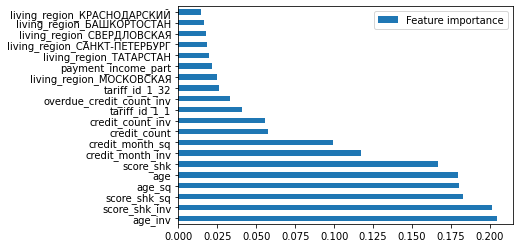

In [97]:
feat_imp.sort_values('Feature importance', ascending=False)[:20].plot(kind='barh')

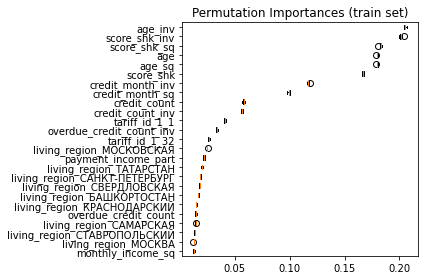

In [98]:
perm_imp_train = permutation_importance(grid_LR_ncorr,
                                        X_tr_scaled_ncorr,
                                        y_train_ncorr,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_ncorr.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

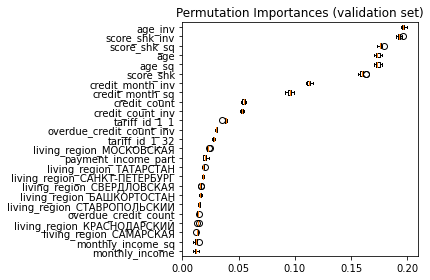

In [99]:
perm_imp_test = permutation_importance(grid_LR_ncorr,
                                       X_val_scaled_ncorr,
                                       y_valid_ncorr,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_ncorr.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

In [100]:
!telegram-send "permutation_importance ready!"

Ввиду мультиколлинеарности мы не можем достоверно определить важность каждого предиктора в модели. Нам необходимо провести очистку переменных от их коррелированных собратьев. Можно попробовать построить дендрограмму коррелированных переменных и выбрать из полученного кластера один предиктор.

In [101]:
quant_cols = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income',
              'credit_count', 'overdue_credit_count','month_payment',
              'payment_income_part', 'age_sq', 'age_inv',
              'credit_sum_sq', 'credit_sum_inv', 'credit_month_sq',
              'credit_month_inv', 'score_shk_sq', 'score_shk_inv',
              'monthly_income_sq', 'monthly_income_inv', 'credit_count_sq',
              'credit_count_inv', 'overdue_credit_count_sq',
              'overdue_credit_count_inv']

In [102]:
def find_corr_features(df, quant_cols):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    corr = spearmanr(df[quant_cols]).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = ward(squareform(distance_matrix))
    dendro = dendrogram(dist_linkage,
                        labels=df[quant_cols].columns.tolist(),
                        ax=ax1, leaf_rotation=90)

    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    fig.tight_layout()
    plt.show()
    
    predictors_clusters = pd.DataFrame(index=dendro["ivl"])
    cluster_ids = fcluster(dist_linkage, 0, criterion="distance")
    predictors_clusters['Clusters'] = cluster_ids
    
    return predictors_clusters.sort_values('Clusters')

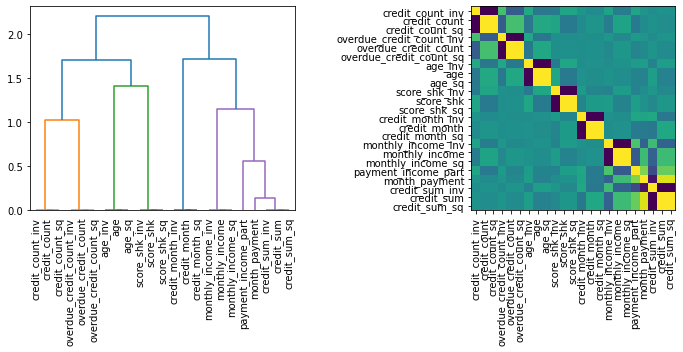

,Clusters
credit_sum_inv,1
month_payment,1
overdue_credit_count_sq,1
credit_sum_sq,2
credit_sum,2
age_inv,2
score_shk,3
score_shk_inv,3
credit_count_inv,3
overdue_credit_count_inv,4


In [103]:
find_corr_features(X_tr_scaled_wcols, quant_cols)

Можно выбирать предикторы автоматически, однако, более целесообразно отбирать те,
которые не были созданы нами самостоятельно, чтобы в дальнейшем сделать pipeline 
попроще.

In [104]:
selected_features = [
    'month_payment', 'credit_sum', 'monthly_income',
    'age', 'credit_month', 'overdue_credit_count',
    'credit_count', 'score_shk', 'score_shk_sq'
]

In [105]:
cols_to_drop_dend = list(set(quant_cols) - set(selected_features))

In [106]:
cols_to_drop_dend 

['monthly_income_sq',
 'credit_sum_sq',
 'payment_income_part',
 'overdue_credit_count_inv',
 'credit_month_sq',
 'credit_month_inv',
 'age_sq',
 'credit_count_sq',
 'credit_sum_inv',
 'age_inv',
 'overdue_credit_count_sq',
 'score_shk_inv',
 'credit_count_inv',
 'monthly_income_inv']

In [107]:
X_tr_scaled_wcols_denddrop = X_tr_scaled_wcols.drop(cols_to_drop_dend, axis=1)
X_val_scaled_wcols_denddrop = X_val_scaled_wcols.drop(cols_to_drop_dend, axis=1)
X_test_scaled_wcols_denddrop = X_test_scaled_wcols.drop(cols_to_drop_dend, axis=1)

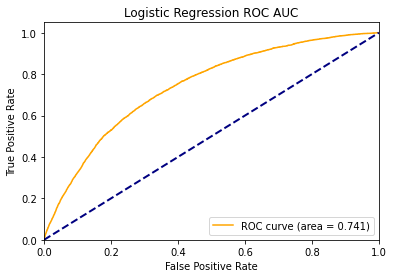

In [108]:
lr_denddrop = make_log_reg(x_train=X_tr_scaled_wcols_denddrop,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_wcols_denddrop,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 model_name='lr_denddrop')

In [109]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,DummyClassifier,lr_baseline,lr_baseline_tuned,lr_baseline_wcols,lr_wcols_nocorr,Grid_LR_ncorr,lr_denddrop
roc-auc,0.500769,0.729256,0.729326,0.740724,0.740565,0.743080,0.740602
precision,0.177318,0.308196,0.308543,0.320245,0.318273,0.320513,0.319415
recall,0.173150,0.646085,0.646251,0.657507,0.656514,0.662142,0.658500
f1,0.175209,0.417322,0.417674,0.430709,0.428710,0.431942,0.430170
logloss,9.910890,10.968681,10.955598,10.567130,10.637577,10.588265,10.606379


Проверим важность признаков после удаления коррелированных столбцов.

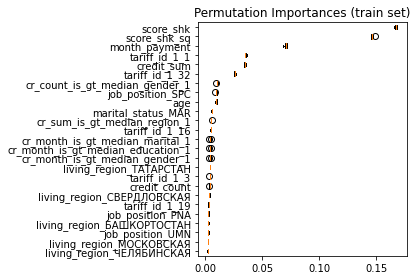

In [110]:
perm_imp_train = permutation_importance(lr_denddrop,
                                        X_tr_scaled_wcols_denddrop,
                                        y_train,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_wcols_denddrop.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

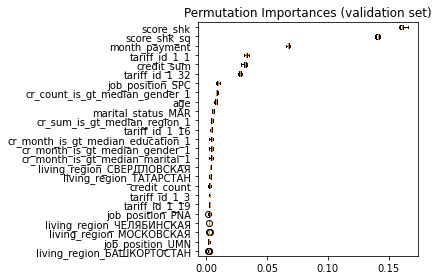

In [111]:
perm_imp_test = permutation_importance(lr_denddrop,
                                       X_val_scaled_wcols_denddrop,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_wcols_denddrop.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

Видим, что важность параметров модели изменилась, посмотрим на значения Шепли для них.

In [112]:
explainer = shap.LinearExplainer(lr_denddrop,
                                 X_tr_scaled_wcols_denddrop,
                                 feature_perturbation="interventional")

shap_values = explainer(X_val_scaled_wcols_denddrop)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


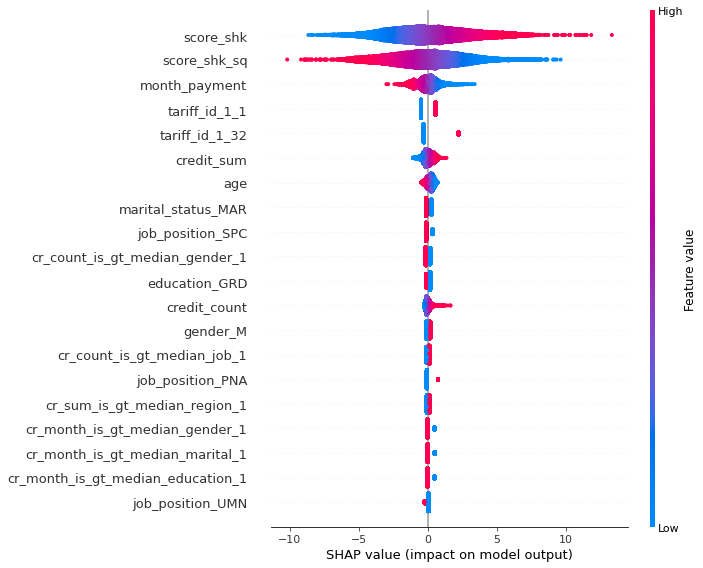

In [113]:
shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop)

In [114]:
# explainer = shap.LinearExplainer(tuned_lr_gr_wcols_denddrop,
#                                  X_tr_scaled_wcols_denddrop,
#                                  feature_perturbation="correlation_dependent")
# shap_values = explainer(X_val_scaled_wcols_denddrop)

In [115]:
# shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop)

**Можно заметить, что на данном этапе наибольшую предиктивную способность носят тарифы 1-32, 1-1; людям, которым были предложены данные тарифы, имели большую конверсию. Также внутренняя скоринговая оценка вносит наибольшую разрешающую способность, люди с высокой оценкой более склонны открывать счет в банке Тинькофф. Высокий ежемесячный платеж, напротив, отпугивает клиентов.**

**Далее обучим модель с большей силой регуляризации, что позволит обнулить некоторые коэффициенты регрессии и, соответственно, откинуть те, которые вносят только шум.**

In [116]:
parameters_grid_C_lt1 = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.2, 0.4, 0.6, 0.8, 1.],
    'solver': ['sag', 'liblinear', 'lbfgs'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(500, 1200, 100)
}

In [117]:
!telegram-send "_C_lt1 grid optimization started!"

In [118]:
%%time
grid_cv_wcols_C_lt1 = find_optimal_params(x_train=X_tr_scaled_wcols_denddrop,
                                          y_train=y_train,
                                          parameters_grid=parameters_grid_C_lt1)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


One or more of the test scores are non-finite: [       nan 0.74478201        nan ...        nan        nan        nan]
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Наилучший ROC AUC = 0.7449
Наилучшие параметры: {'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Wall time: 4h 3min 47s


In [119]:
!telegram-send "_C_lt1 grid optimization is over!"

In [120]:
best_params_wcols_C_lt1 = grid_cv_wcols_C_lt1.best_params_

In [121]:
# best_params_wcols_C_lt1 = {
#     'C': 1.0,
#     'l1_ratio': 0.2,
#     'max_iter': 600,
#     'penalty': 'l2',
#     'solver': 'lbfgs'
# }

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


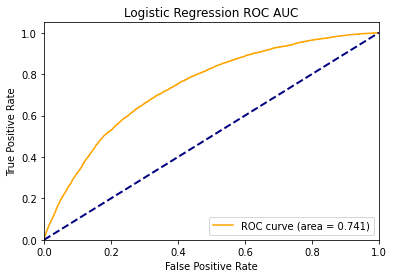

In [122]:
tuned_lr_gr_wcols_C_lt1 = make_log_reg(x_train=X_tr_scaled_wcols_denddrop,
                                       y_train=y_train,
                                       x_valid=X_val_scaled_wcols_denddrop,
                                       y_valid=y_valid,
                                       results_df=lr_metrics,
                                       parameters=best_params_wcols_C_lt1,
                                       model_name='lr_tuned_denddrop_C_lt1')

In [123]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,DummyClassifier,lr_baseline,lr_baseline_tuned,lr_baseline_wcols,lr_wcols_nocorr,Grid_LR_ncorr,lr_denddrop,lr_tuned_denddrop_C_lt1
roc-auc,0.500769,0.729256,0.729326,0.740724,0.740565,0.743080,0.740602,0.740601
precision,0.177318,0.308196,0.308543,0.320245,0.318273,0.320513,0.319415,0.319467
recall,0.173150,0.646085,0.646251,0.657507,0.656514,0.662142,0.658500,0.658500
f1,0.175209,0.417322,0.417674,0.430709,0.428710,0.431942,0.430170,0.430217
logloss,9.910890,10.968681,10.955598,10.567130,10.637577,10.588265,10.606379,10.604367


### Отсев переменных не обладающих предсказательной способностью

Далее мы проведем отсев сконструированных переменных на основании значения их коэффициентов в уравнении регресии.

In [124]:
tuned_lr_gr_wcols_C_lt1_coef = pd.DataFrame(
    index=['intercept'] + X_tr_scaled_wcols_denddrop.columns.to_list(),
    data=[tuned_lr_gr_wcols_C_lt1.intercept_[0]] + tuned_lr_gr_wcols_C_lt1.coef_[0].tolist(),
    columns=['coef']).sort_values('coef', ascending=False)

In [125]:
indices_to_drop = tuned_lr_gr_wcols_C_lt1_coef.query('-0.1 < coef < 0.1').index
indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]

In [126]:
def filter_coefs(X_train, X_valid, coef_df, results_df, threshold, model_params):
    indices_to_drop = coef_df.iloc[:,[-1]].query('-@threshold < coef < @threshold').index
    indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]
    step = 0
    
    while indices_to_drop.shape[0] != 0:
        X_train = X_train.drop(indices_to_drop, axis=1)
        X_valid = X_valid.drop(indices_to_drop, axis=1)
        print(f'Шаг номер: {step}')
        print(f'Были выброшены: {indices_to_drop}')
        print('-' * 25)
        
        log_reg = make_log_reg(x_train=X_train,
                               y_train=y_train,
                               x_valid=X_valid,
                               y_valid=y_valid,
                               results_df=results_df,
                               parameters=model_params,
                               model_name='filter_coefs_' + str(step))
        
        coefs = pd.DataFrame(
            index=['intercept'] + X_valid.columns.to_list(),
            data=[log_reg.intercept_[0]] + log_reg.coef_[0].tolist(),
            columns=['coef_step_' + str(step)])
        
        coef_df = coef_df.merge(coefs, how='left', left_index=True, right_index=True)
        
        query_str = f'-@threshold < coef_step_{step} < @threshold'
        indices_to_drop = coef_df.query(query_str).index
        indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]
        step += 1
        
    return coef_df

Для максимального обнуления коэффициентов регрессии можно применить лассо регрессию - L1. Полученные малые значения коэффициентов будут основанием для удаления переменной из модели.

Шаг номер: 0
Были выброшены: Index(['age_is_gt_median_education_1', 'cr_sum_is_gt_median_education_1',
       'score_is_gt_median_job_1', 'age_is_gt_median_marital_1',
       'score_is_gt_median_marital_1', 'cr_month_is_gt_median_region_1',
       'cr_sum_is_gt_median_gender_1', 'age_is_gt_median_region_1',
       'score_is_gt_median_education_1', 'cr_count_is_gt_median_marital_1',
       'income_is_gt_median_job_1', 'cr_count_is_gt_median_education_1',
       'age_is_gt_median_gender_1', 'cr_sum_is_gt_median_job_1',
       'score_is_gt_median_region_1', 'income_is_gt_median_marital_1',
       'income_is_gt_median_gender_1', 'cr_count_is_gt_median_region_1',
       'income_is_gt_median_education_1', 'cr_sum_is_gt_median_marital_1',
       'income_is_gt_median_region_1', 'age_is_gt_median_job_1',
       'cr_month_is_gt_median_job_1', 'score_is_gt_median_gender_1'],
      dtype='object')
-------------------------


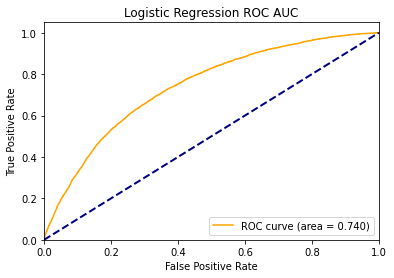

Шаг номер: 1
Были выброшены: Index(['overdue_count_is_gt_median_education_1',
       'overdue_count_is_gt_median_region_1',
       'overdue_count_is_gt_median_gender_1',
       'overdue_count_is_gt_median_marital_1',
       'overdue_count_is_gt_median_job_1'],
      dtype='object')
-------------------------


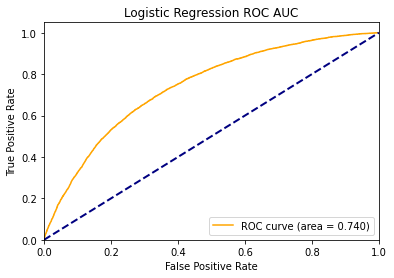

,DummyClassifier,lr_baseline,lr_baseline_tuned,lr_baseline_wcols,lr_wcols_nocorr,Grid_LR_ncorr,lr_denddrop,lr_tuned_denddrop_C_lt1,filter_coefs_0,filter_coefs_1
roc-auc,0.500769,0.729256,0.729326,0.740724,0.740565,0.743080,0.740602,0.740601,0.739981,0.739984
precision,0.177318,0.308196,0.308543,0.320245,0.318273,0.320513,0.319415,0.319467,0.318646,0.318646
recall,0.173150,0.646085,0.646251,0.657507,0.656514,0.662142,0.658500,0.658500,0.656017,0.656017
f1,0.175209,0.417322,0.417674,0.430709,0.428710,0.431942,0.430170,0.430217,0.428943,0.428943
logloss,9.910890,10.968681,10.955598,10.567130,10.637577,10.588265,10.606379,10.604367,10.619462,10.619462


In [127]:
params = {
    'penalty':'l1',
    'C':0.2,
    'solver':'liblinear',
    'max_iter':1500
}

coef_df = filter_coefs(X_tr_scaled_wcols_denddrop,
             X_val_scaled_wcols_denddrop,
             tuned_lr_gr_wcols_C_lt1_coef,
             lr_metrics, 0.1, params)

lr_metrics.style.highlight_max(axis=1, color='lightblue')

Таким образом, на основании близости к нулю коэффициентов при переменных будут выброшены вышеуказанные предикторы.

In [128]:
cols_to_drop = coef_df.loc[coef_df.iloc[:,[-1]].isna()['coef_step_1'].values,:].index
cols_to_drop

Index(['age_is_gt_median_education_1', 'cr_sum_is_gt_median_education_1',
       'score_is_gt_median_job_1', 'age_is_gt_median_marital_1',
       'score_is_gt_median_marital_1', 'cr_month_is_gt_median_region_1',
       'cr_sum_is_gt_median_gender_1', 'age_is_gt_median_region_1',
       'score_is_gt_median_education_1', 'cr_count_is_gt_median_marital_1',
       'income_is_gt_median_job_1', 'cr_count_is_gt_median_education_1',
       'age_is_gt_median_gender_1', 'cr_sum_is_gt_median_job_1',
       'score_is_gt_median_region_1', 'income_is_gt_median_marital_1',
       'income_is_gt_median_gender_1', 'cr_count_is_gt_median_region_1',
       'income_is_gt_median_education_1', 'cr_sum_is_gt_median_marital_1',
       'income_is_gt_median_region_1', 'age_is_gt_median_job_1',
       'cr_month_is_gt_median_job_1', 'score_is_gt_median_gender_1',
       'overdue_count_is_gt_median_education_1',
       'overdue_count_is_gt_median_region_1',
       'overdue_count_is_gt_median_gender_1',
       'over

Видим, что теперь у нас нет сконструированных признаков с низким коэффициентом. Следовательно мы убрали лишние переменные.

Также можно проверить как изменится предсказательная сила переменной при удалении `score_shk_sq`.

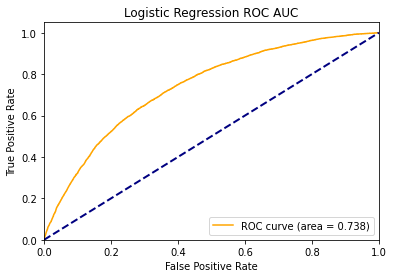

In [129]:
cols_to_drop_1 = cols_to_drop.append(pd.Index(['score_shk_sq']))
lr_drop_shk_sq = make_log_reg(x_train=X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                              y_train=y_train,
                              x_valid=X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                              y_valid=y_valid,
                              results_df=lr_metrics,
                              parameters=params,
                              model_name='lr_drop_shk_sq')

In [130]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,DummyClassifier,lr_baseline,lr_baseline_tuned,lr_baseline_wcols,lr_wcols_nocorr,Grid_LR_ncorr,lr_denddrop,lr_tuned_denddrop_C_lt1,filter_coefs_0,filter_coefs_1,lr_drop_shk_sq
roc-auc,0.500769,0.729256,0.729326,0.740724,0.740565,0.743080,0.740602,0.740601,0.739981,0.739984,0.737708
precision,0.177318,0.308196,0.308543,0.320245,0.318273,0.320513,0.319415,0.319467,0.318646,0.318646,0.315667
recall,0.173150,0.646085,0.646251,0.657507,0.656514,0.662142,0.658500,0.658500,0.656017,0.656017,0.649727
f1,0.175209,0.417322,0.417674,0.430709,0.428710,0.431942,0.430170,0.430217,0.428943,0.428943,0.424899
logloss,9.910890,10.968681,10.955598,10.567130,10.637577,10.588265,10.606379,10.604367,10.619462,10.619462,10.692928


In [131]:
explainer = shap.LinearExplainer(lr_drop_shk_sq,
                                 X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                                 feature_perturbation="interventional")
shap_values = explainer(X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1))

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


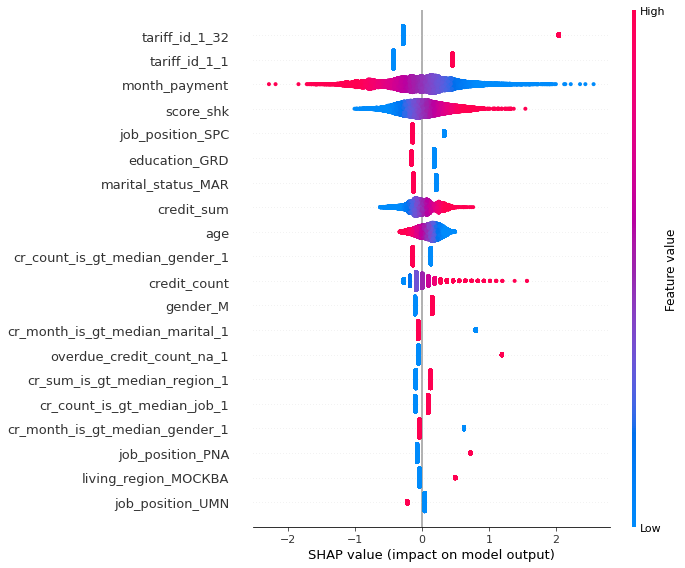

In [132]:
shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1))

Согласно полученным результатам, можно заключить, что удаление столбца `score_shk_sq` приводит ко значительному ухудшению предсказательной способности модели. Значения Шепли при этом также уменьшаются в абсолютном значении в 3 раза.

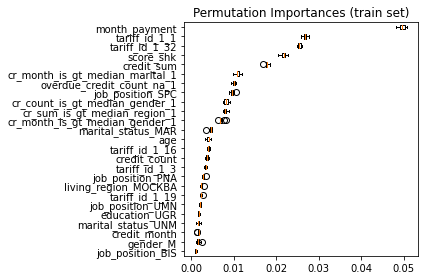

In [133]:
perm_imp_train = permutation_importance(lr_drop_shk_sq,
                                        X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                                        y_train,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1).columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

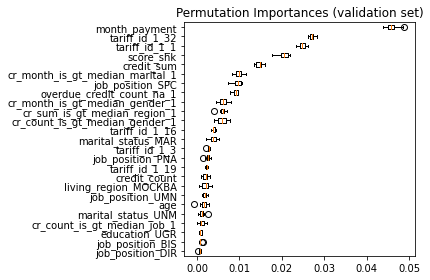

In [134]:
perm_imp_test = permutation_importance(lr_drop_shk_sq,
                                       X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1).columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

$logit(p) = log(\frac{p}{1-p}) = \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k.$

# Конструирование попарных взаимодействий

До этого момента в моделях не были заложены попарные взаимодействия между предикторами, также для улучшения предсказательной способности модели произведем биннинг некоторых количественных переменных. 

Для оценки качества и целесообразности биннинга переменных воспользуемся библиотекой [PyWoE](https://pypi.org/project/pywoe/).

In [135]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

In [136]:
X_train = train.drop('open_account_flg', axis=1)
y_train = train['open_account_flg']

X_valid = valid.drop('open_account_flg', axis=1)
y_valid = valid['open_account_flg']

X_test = test.drop('open_account_flg', axis=1)
y_test = test['open_account_flg']

In [137]:
X_train.dtypes

gender                   object
age                     float64
marital_status           object
job_position             object
credit_sum              float64
credit_month              int64
tariff_id                object
score_shk               float64
education                object
living_region            object
monthly_income          float64
credit_count            float64
overdue_credit_count    float64
month_payment           float64
payment_income_part     float64
dtype: object

In [138]:
qua_cols = X_train.dtypes[X_train.dtypes != 'object'].index

In [139]:
(X_train[qua_cols] == 0).sum()

age                          0
credit_sum                   0
credit_month                 0
score_shk                    2
monthly_income               0
credit_count             18062
overdue_credit_count    107933
month_payment                0
payment_income_part          0
dtype: int64

In [140]:
X_train[qua_cols] = X_train[qua_cols] - 0.001
(X_train[qua_cols] == 0).sum()

age                     0
credit_sum              0
credit_month            0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
month_payment           0
payment_income_part     0
dtype: int64

In [141]:
Xs_datasets = [X_train, X_valid, X_test]

In [142]:
for indicator in tqdm(qua_cols):
    for df in Xs_datasets:
        df[indicator + '_sq'] = df[indicator] ** 2
        df[indicator + '_inv'] = (1 / df[indicator]).replace([np.inf, -np.inf], -1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.61it/s]


In [143]:
qua_cols = X_train.dtypes[X_train.dtypes != 'object'].index

In [144]:
X_train[qua_cols]

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,month_payment,payment_income_part,age_sq,...,monthly_income_sq,monthly_income_inv,credit_count_sq,credit_count_inv,overdue_credit_count_sq,overdue_credit_count_inv,month_payment_sq,month_payment_inv,payment_income_part_sq,payment_income_part_inv
87470,29.999,4989.999,5.999,0.437890,23999.999,2.999,0.999,831.665667,0.033653,899.940001,...,5.760000e+08,0.000042,8.994001,0.333444,0.998001,1.001001,6.916678e+05,0.001202,0.001133,29.715229
77449,44.999,27346.999,9.999,0.667692,24999.999,2.999,-0.001,2734.699000,0.108388,2024.910001,...,6.250000e+08,0.000040,8.994001,0.333444,0.000001,-1000.000000,7.478579e+06,0.000366,0.011748,9.226114
97073,41.999,11509.999,23.999,0.377687,29999.999,2.999,-0.001,479.582333,0.014986,1763.916001,...,8.999999e+08,0.000033,8.994001,0.333444,0.000001,-1000.000000,2.299992e+05,0.002085,0.000225,66.728452
6498,38.999,30312.999,9.999,0.495607,29999.999,1.999,-0.001,3031.299000,0.100043,1520.922001,...,8.999999e+08,0.000033,3.996001,0.500250,0.000001,-1000.000000,9.188774e+06,0.000330,0.010009,9.995669
156564,25.999,46971.899,9.999,0.430449,69999.999,0.999,-0.001,4697.189000,0.066103,675.948001,...,4.900000e+09,0.000014,0.998001,1.001001,0.000001,-1000.000000,2.206358e+07,0.000213,0.004370,15.127972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83528,38.999,20976.999,9.999,0.403381,27999.999,0.999,-0.001,2097.699000,0.073918,1520.922001,...,7.839999e+08,0.000036,0.998001,1.001001,0.000001,-1000.000000,4.400341e+06,0.000477,0.005464,13.528531
138673,64.999,25190.999,9.999,0.321701,13699.999,-0.001,-0.001,2519.099000,0.182876,4224.870001,...,1.876900e+08,0.000073,0.000001,-1000.000000,0.000001,-1000.000000,6.345860e+06,0.000397,0.033444,5.468189
141915,36.999,46277.999,9.999,0.613858,37499.999,1.999,-0.001,4627.799000,0.122408,1368.926001,...,1.406250e+09,0.000027,3.996001,0.500250,0.000001,-1000.000000,2.141652e+07,0.000216,0.014984,8.169401
35227,25.999,5283.999,9.999,0.368292,34999.999,3.999,-0.001,528.399000,0.014097,675.948001,...,1.225000e+09,0.000029,15.992001,0.250063,0.000001,-1000.000000,2.792055e+05,0.001893,0.000199,70.936360


Далее проведем степенное преобразование [Йео-Джонсона](https://en.wikipedia.org/wiki/Power_transform), которое также допускает нулевые и отрицательные значения. Закон преобразования гласит:


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/2a99e24c81226f3d0547c471281197ea265553c5">

In [145]:
rs = RobustScaler(with_scaling=True,
                  unit_variance=True)

rs.fit(X_train[qua_cols])

for df in Xs_datasets:
    df[qua_cols] = rs.transform(df[qua_cols])

In [146]:
pt = PowerTransformer(standardize=True,
                      method='yeo-johnson')

pt.fit(X_train[qua_cols])

for df in Xs_datasets:
    df[qua_cols] = pt.transform(df[qua_cols])

<AxesSubplot:>

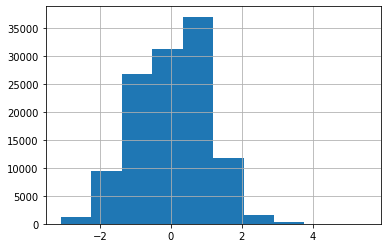

In [147]:
X_train['monthly_income'].hist()

В качестве меры целесообразности и качества биннинга будем использовать вес каждой категории (Weight of evidence - *WoE*), который может быть расчитан по формуле: <img src='https://4.bp.blogspot.com/-X1m0w40w0xg/V9V_7LS1AQI/AAAAAAAAFWc/f4bgPvE1In8Q13kGGBghp98MeWma8KgqACLcB/s1600/woe.png' img>
т.е. как логарифм отношения относительных частот двух классов в данной категории. Группировка выполняется так, чтобы максимизировать разницу между классами таргетной переменной.

При работе с данным показателем нужно придерживаться четырех правил:
* Количество категорий не должно превышать 10
* Каждая категория должна содержать не менее 5% наблюдений
* Категории не должны содержать нулевого окличества событий или не-событий
* Пропущенные значения группируются в отдельную категорию

Также стоит учесть, что в идеале *WoE* непропущенных значений должно быть монотонным, восходя от отрицательных значений к положительным или наоборот. Важно не столько абсолютное значение *WoE*, как разница между *WoE* групп. Чем больше разница между последующими категориями, тум выше прогнозная сила данной переменной.


In [148]:
import woe1

In [149]:
not_int_cols = qua_cols[~qua_cols.isin(['credit_month',
                                        'credit_month_sq',
                                        'credit_month_inv'])]

In [150]:
for col in not_int_cols:
    woe = woe1.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
    # Зададим 10 бинов с не менее 10 записей, количественный предиктор и бинарный таргет.
    woe.fit(X_train[col], y_train.astype('int'))
    woe.transform(X_train[col])
    try:
        woe_mon = woe.force_monotonic()
    except:
        print(col, ' - unable to force_monotonic')
    print(f'\n{col}\n{woe_mon.bins}\n')


age
       mean   bad    obs   good       woe      bins labels
0  0.236624  4971  21008  16037 -0.372229      -inf      0
1  0.163369  6342  38820  32478  0.089863 -1.099322      1
2  0.162931  9726  59694  49968  0.093074 -0.061003      2


credit_sum
       mean    bad    obs   good       woe      bins labels
0  0.275881   2998  10867   7869 -0.578520      -inf      0
1  0.178840  11662  65209  53547 -0.019282 -1.315133      1
2  0.169936   3690  21714  18024  0.042572  0.347444      2
3  0.127646   1387  10866   9479  0.378430  1.042906      3
4  0.119823   1302  10866   9564  0.450598  1.462933      4

score_shk  - unable to force_monotonic

score_shk
       mean    bad    obs   good       woe      bins labels
0  0.275881   2998  10867   7869 -0.578520      -inf      0
1  0.178840  11662  65209  53547 -0.019282 -1.315133      1
2  0.169936   3690  21714  18024  0.042572  0.347444      2
3  0.127646   1387  10866   9479  0.378430  1.042906      3
4  0.119823   1302  10866   9564  0


payment_income_part_sq
       mean   bad    obs   good       woe      bins labels
0  0.214246  2328  10866   8538 -0.243989      -inf      0
1  0.201362  2188  10866   8678 -0.165703 -1.348355      1
2  0.194570  2114  10865   8751 -0.122920 -1.060975      2
3  0.187558  2038  10866   8828 -0.077547 -0.783051      3
4  0.178095  1935  10865   8930 -0.014197 -0.493981      4
5  0.176606  1919  10866   8947 -0.003992 -0.194172      5
6  0.171644  3730  21731  18001  0.030513  0.105396      6
7  0.160147  1740  10865   9125  0.113627  0.705867      7
8  0.148445  1613  10866   9253  0.203346  1.039161      8
9  0.131971  1434  10866   9432  0.340134  1.448029      9

payment_income_part_inv  - unable to force_monotonic

payment_income_part_inv
       mean   bad    obs   good       woe      bins labels
0  0.214246  2328  10866   8538 -0.243989      -inf      0
1  0.201362  2188  10866   8678 -0.165703 -1.348355      1
2  0.194570  2114  10865   8751 -0.122920 -1.060975      2
3  0.187558 

По результатам разбиения можно сказать, что для `age`, `overdue_credit_count` и `credit_count` и их производных биннинг не даст результатов, поскольку количество бинов - 2. Теперь оптимизируем бины  по метрике *roc_auc* с использованием CART.

In [151]:
bin_cols = ['credit_sum', 'score_shk', 'monthly_income',
            'month_payment', 'payment_income_part',
            'credit_sum_sq', 'credit_sum_inv', 'score_shk_sq',
            'score_shk_inv', 'monthly_income_sq', 'monthly_income_inv',
            'month_payment_sq', 'month_payment_inv',
            'payment_income_part_sq', 'payment_income_part_inv'] 

In [152]:
columns = []
fitted_bins = []
column_IV = []
bins_number = []

for col in bin_cols:
    woe = woe1.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
    woe.fit(X_train[col], train['open_account_flg'].astype('int'))
    
    woe_optimized = woe.optimize(max_depth=4,
                                 scoring='roc_auc',
                                 cv=5,
                                 min_samples_leaf=50)
    columns.append(col)
    fitted_bins.append(woe_optimized.bins.bins.values)
    column_IV.append(woe_optimized.iv)
    bins_number.append(woe_optimized.bins.bins.shape[0])
    
binning_info = pd.DataFrame({'Переменная':columns,
                             'Бины':fitted_bins,
                             'IV':column_IV,
                             'Количество бинов':bins_number})\
                            .sort_values('IV', ascending=False)\
                            .set_index('Переменная')

In [153]:
binning_info

,Бины,IV,Количество бинов
Переменная,,,
month_payment,"[-inf, -2.0729215145111084, -1.349581480026245...",0.077199,8
month_payment_sq,"[-inf, -1.7017749547958374, -1.325356781482696...",0.077199,8
month_payment_inv,"[-inf, -2.1911081075668335, -1.323523700237274...",0.077199,8
credit_sum,"[-inf, -2.33443284034729, -1.7860615849494934,...",0.076708,8
credit_sum_sq,"[-inf, -1.7578452825546265, -1.56692636013031,...",0.076708,8
credit_sum_inv,"[-inf, -1.9214598536491394, -1.168094694614410...",0.076708,8
score_shk,"[-inf, -2.6325167417526245, -0.502278685569763...",0.028251,8
score_shk_sq,"[-inf, -2.3391940593719482, -0.527974128723144...",0.028251,8
score_shk_inv,"[-inf, -1.0486171245574951, -0.937468498945236...",0.028135,8


Нашей задачей является категоризация переменной при условии максимально эффективного разделения одного класса от другого. Существует возможность разбить все переменные на множество категорий, однако, это чревато переобучением и усложнием модели. Возможным вариантом является сравнение "полезности" предиктора с остальными переменными. Самый простой вариант - использовать IV (от [information value](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/)) или информационное значение. Его можно вычислить для отдельной категории и для всей переменной. Информационное значение для категории вычисляется как разность между относительной частотой класса 0 и относительной частотой класса 1 в данной категории, умноженная на натуральный логарифм отношения этих частот.

$ IV = \sum_{i = 1}^k(IV_i) = \sum_{i = 1}^k(F_i^0 - F_i^1)ln(\frac{F_i^0}{F_i^1})$




<table  width="50%" cellspacing="2" style="margin: 0px auto;">
    <tbody>
        <tr>
            <th>Information Value</th>
            <th>Предсказательная способность</th>
        </tr>
        <tr>
            <td>&lt;0.02</td>
            <th>не обладает</th>
        </tr>
        <tr>
            <td>0.02-0.1</td>
            <th>слабая</th>
        </tr>
        <tr>
            <td>0.1-0.3</td>
            <th>средняя</th>
        </tr>
        <tr>
            <td>0.3-0.5</td>
            <th>сильная</th>
        </tr>
        <tr>
            <td>&gt;0.5</td>
            <th>подозрительная (утечка?)</th>
        </tr>
    </tbody>
</table>


Отбросим `monthly_income_sq` и `monthly_income_inv` поскольку они не обладают никакой предсказательной силой. Для остальных переменных создадим соответствующие категории на основе полученных бинов.

In [154]:
for indicator in tqdm(['monthly_income_sq', 'monthly_income_inv']):
    for df in Xs_datasets:
        df.drop(indicator, axis=1, inplace=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.64it/s]


In [155]:
cols_to_categorize = binning_info[binning_info.IV > 0.02].index

for col in cols_to_categorize:
    for df in Xs_datasets:
        df[col + '_cat'] = pd.cut(df[col], binning_info.loc[col,'Бины']).astype('object')

In [156]:
cat_cols = X_train.dtypes[X_train.dtypes == 'object'].index

In [157]:
X_train_label = pd.get_dummies(X_train, columns=cat_cols, drop_first=True).copy()
X_valid_label = pd.get_dummies(X_valid, columns=cat_cols, drop_first=True).copy()
X_test_label = pd.get_dummies(X_test, columns=cat_cols, drop_first=True).copy()

In [158]:
labeled_Xs_datasets = [X_train_label, X_valid_label, X_test_label]

## Построение модели с категориями количественных переменных

In [159]:
lr_metrics_cat = pd.DataFrame(index=['roc-auc', 'precision',
                                 'recall', 'f1', 'logloss'])

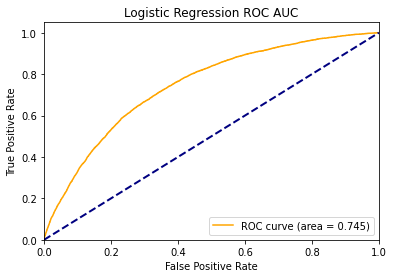

In [160]:
lr_baseline_cat = make_log_reg(x_train=X_train_label,
                               y_train=y_train,
                               x_valid=X_valid_label,
                               y_valid=y_valid,
                               results_df=lr_metrics_cat,
                               model_name='lr_baseline_cat')

In [161]:
lr_metrics_cat

,lr_baseline_cat
roc-auc,0.744886
precision,0.282262
recall,0.790763
f1,0.416024
logloss,13.496773


## Построение взаимодействия категории и значения переменных

Как можно заметить, мы увеличили характеристику ROC AUC за счет добавления новых переменных, т.о. мы создали модель логистической регрессии с дискретизированными признаками и одним глобальным наклоном гиперплоскости, теперь можно включить взаимодействие, указывающее на категорию точки данных и ее точное расположение по данной оси в пространстве - произведение индикатора категории и исходной переменной.

In [162]:
for df in labeled_Xs_datasets:    
    for qua_col in cols_to_categorize:
        cols_to_mul = [col for col in df.columns
                       if (qua_col + '_cat') in col]
        for cat_col in cols_to_mul:
            df[cat_col + '_mul'] = df[qua_col] * df[cat_col]
        df.drop(qua_col, axis=1, inplace=True)

## Построение модели с взаимодействием категорий и количественных переменных

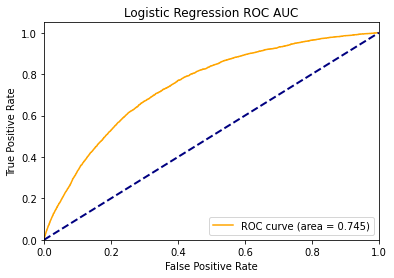

In [163]:
lr_qua_cat = make_log_reg(x_train=X_train_label,
                               y_train=y_train,
                               x_valid=X_valid_label,
                               y_valid=y_valid,
                               results_df=lr_metrics_cat,
                               model_name='lr_qua_cat')

In [164]:
lr_metrics_cat

,lr_baseline_cat,lr_qua_cat
roc-auc,0.744886,0.744928
precision,0.282262,0.281058
recall,0.790763,0.796557
f1,0.416024,0.415508
logloss,13.496773,13.624586


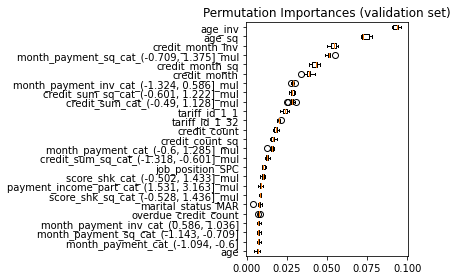

In [165]:
perm_imp_test = permutation_importance(lr_qua_cat,
                                       X_valid_label,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_valid_label.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

## Снижение размерности путем отсеивания признаков


На данном этапе отбираем признаки по их важности, для этого воспользуемся рекурсивным удалением признаков с перекрестной проверкой, которая реализована в классе RFECV библиотеки scikit-learn.

In [166]:
from sklearn.feature_selection import RFECV

lr_qua_cat_2 = LogisticRegression(class_weight='balanced',
                                  random_state=RND_STATE)

rfecv = RFECV(lr_qua_cat_2,
              scoring='roc_auc',
              n_jobs=-1,
              verbose=5)

In [167]:
rfecv.fit(X_train_label, y_train)

Fitting estimator with 283 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 282 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 281 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 280 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 279 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 278 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 277 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 276 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 275 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 274 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 273 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 272 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 271 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 270 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 269 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 268 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 267 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 266 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 265 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 264 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 263 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 262 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 261 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 260 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 259 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 258 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 257 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 256 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 255 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 254 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 253 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 252 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 251 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 250 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 249 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 248 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 247 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 246 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 245 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 244 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 243 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 242 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 241 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 240 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 239 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 238 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 237 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 236 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 235 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 234 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 233 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 232 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 231 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 230 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 229 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 228 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 227 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 226 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 225 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 224 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 223 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 222 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 221 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 220 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 219 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 218 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 217 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 216 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 215 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 214 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 213 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 212 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 211 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 210 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 209 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 208 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 207 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

RFECV(estimator=LogisticRegression(class_weight='balanced', random_state=777),
      n_jobs=-1, scoring='roc_auc', verbose=5)

In [168]:
print(rfecv.n_features_)
print(X_train_label.loc[:,rfecv.support_].columns)

206
Index(['credit_month', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'age_sq', 'age_inv', 'credit_month_sq',
       'credit_month_inv', 'credit_count_sq', 'overdue_credit_count_sq',
       ...
       'score_shk_inv_cat_(-0.855, -0.854]_mul',
       'score_shk_inv_cat_(-0.763, 0.0871]_mul',
       'score_shk_inv_cat_(0.0871, 5.429]_mul',
       'payment_income_part_sq_cat_(-1.383, -0.532]_mul',
       'payment_income_part_sq_cat_(-0.532, -0.529]_mul',
       'payment_income_part_sq_cat_(0.691, 1.094]_mul',
       'payment_income_part_sq_cat_(1.094, 1.588]_mul',
       'payment_income_part_cat_(-0.415, -0.412]_mul',
       'payment_income_part_cat_(0.999, 1.531]_mul',
       'payment_income_part_cat_(1.531, 3.163]_mul'],
      dtype='object', length=206)


In [169]:
# predictive_cols = ['age', 'credit_sum', 'credit_month', 'score_shk',
#                    'monthly_income', 'credit_count', 'overdue_credit_count',
#                    'month_payment', 'age_sq', 'age_inv', 'credit_sum_sq',
#                    'credit_sum_inv', 'credit_month_sq', 'credit_month_inv',
#                    'score_shk_inv', 'credit_count_sq', 'overdue_credit_count_sq',
#                    'month_payment_inv', 'payment_income_part_sq', 'payment_income_part_inv',
#                    'gender_M', 'marital_status_MAR', 'job_position_BIS', 'job_position_BIU',
#                    'job_position_DIR', 'job_position_INP', 'job_position_NOR',
#                    'job_position_PNA', 'job_position_PNI', 'job_position_SPC',
#                    'job_position_UMN', 'job_position_WRK', 'job_position_WRP',
#                    'tariff_id_1_1', 'tariff_id_1_16', 'tariff_id_1_17',
#                    'tariff_id_1_19', 'tariff_id_1_2', 'tariff_id_1_21',
#                    'tariff_id_1_23', 'tariff_id_1_24', 'tariff_id_1_25',
#                    'tariff_id_1_3', 'tariff_id_1_32', 'tariff_id_1_41',
#                    'tariff_id_1_43', 'tariff_id_1_5', 'tariff_id_1_7',
#                    'tariff_id_1_9', 'tariff_id_1_91', 'tariff_id_1_99',
#                    'education_PGR', 'education_SCH', 'living_region_АДЫГЕЯ',
#                    'living_region_АСТРАХАНСКАЯ', 'living_region_БАШКОРТОСТАН',
#                    'living_region_ВЛАДИМИРСКАЯ', 'living_region_ВОЛОГОДСКАЯ',
#                    'living_region_ДАГЕСТАН', 'living_region_ЕВРЕЙСКАЯ',
#                    'living_region_КАБАРДИНО-БАЛКАРСКАЯ', 'living_region_КАЛИНИНГРАДСКАЯ',
#                    'living_region_КАЛМЫКИЯ', 'living_region_КАРАЧАЕВО-ЧЕРКЕССКАЯ',
#                    'living_region_КАРЕЛИЯ', 'living_region_КОСТРОМСКАЯ',
#                    'living_region_КУРГАНСКАЯ', 'living_region_ЛИПЕЦКАЯ',
#                    'living_region_МАГАДАНСКАЯ', 'living_region_МАРИЙЭЛ',
#                    'living_region_МОРДОВИЯ', 'living_region_МОСКВА',
#                    'living_region_МУРМАНСКАЯ', 'living_region_НЕ УКАЗАН',
#                    'living_region_НЕНЕЦКИЙ', 'living_region_НИЖЕГОРОДСКАЯ',
#                    'living_region_НОВГОРОДСКАЯ', 'living_region_ОРЕНБУРГСКАЯ',
#                    'living_region_ПЕНЗЕНСКАЯ', 'living_region_ПЕРМСКИЙ',
#                    'living_region_ПРИМОРСКИЙ', 'living_region_ПСКОВСКАЯ',
#                    'living_region_РЯЗАНСКАЯ', 'living_region_САМАРСКАЯ',
#                    'living_region_САРАТОВСКАЯ', 'living_region_САХА/ЯКУТИЯ/',
#                    'living_region_САХАЛИНСКАЯ', 'living_region_СВЕРДЛОВСКАЯ',
#                    'living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ', 'living_region_СМОЛЕНСКАЯ',
#                    'living_region_СТАВРОПОЛЬСКИЙ', 'living_region_ТАМБОВСКАЯ',
#                    'living_region_ТАТАРСТАН', 'living_region_ТОМСКАЯ',
#                    'living_region_ТЫВА', 'living_region_УЛЬЯНОВСКАЯ',
#                    'living_region_ХАКАСИЯ', 'living_region_ЯМАЛО-НЕНЕЦКИЙ',
#                    'living_region_ЯРОСЛАВСКАЯ', 'credit_sum_cat_(-1.33, -0.49]',
#                    'credit_sum_cat_(-0.49, 1.119]', 'credit_sum_cat_(1.119, 2.016]',
#                    'credit_sum_sq_cat_(-1.315, -0.6]', 'credit_sum_sq_cat_(-0.6, 1.214]',
#                    'credit_sum_sq_cat_(1.214, 1.922]', 'credit_sum_inv_cat_(-1.888, -1.16]',
#                    'credit_sum_inv_cat_(-1.16, 0.486]', 'credit_sum_inv_cat_(0.486, 1.27]',
#                    'month_payment_cat_(-1.919, -1.35]', 'month_payment_cat_(-1.096, -0.507]',
#                    'month_payment_cat_(-0.507, 1.228]', 'month_payment_cat_(1.228, 2.481]',
#                    'month_payment_sq_cat_(-1.639, -1.326]', 'month_payment_sq_cat_(-1.144, -0.615]',
#                    'month_payment_sq_cat_(-0.615, 1.322]', 'month_payment_sq_cat_(1.322, 2.183]',
#                    'month_payment_inv_cat_(-2.185, -1.269]', 'month_payment_inv_cat_(-1.269, 0.502]',
#                    'month_payment_inv_cat_(0.502, 1.038]', 'month_payment_inv_cat_(1.102, 1.29]',
#                    'month_payment_inv_cat_(1.29, 1.963]', 'score_shk_cat_(1.43, 1.847]',
#                    'score_shk_cat_(2.197, 3.088]', 'score_shk_sq_cat_(1.433, 1.831]',
#                    'score_shk_sq_cat_(2.162, 2.996]', 'score_shk_inv_cat_(-1.106, -0.964]',
#                    'score_shk_inv_cat_(-0.894, -0.795]', 'score_shk_inv_cat_(0.0887, 5.137]',
#                    'payment_income_part_cat_(0.504, 0.505]', 'payment_income_part_sq_cat_(0.547, 0.549]',
#                    'payment_income_part_inv_cat_(-0.51, -0.508]', 'credit_sum_cat_(-2.338, -1.816]_mul',
#                    'credit_sum_cat_(-1.816, -1.516]_mul', 'credit_sum_cat_(-1.516, -1.33]_mul',
#                    'credit_sum_cat_(-0.49, 1.119]_mul', 'credit_sum_sq_cat_(-1.76, -1.581]_mul',
#                    'credit_sum_sq_cat_(-1.581, -1.429]_mul', 'credit_sum_sq_cat_(-1.429, -1.315]_mul',
#                    'credit_sum_inv_cat_(-1.16, 0.486]_mul', 'credit_sum_inv_cat_(1.27, 1.471]_mul',
#                    'credit_sum_inv_cat_(1.471, 1.836]_mul', 'month_payment_cat_(-1.919, -1.35]_mul',
#                    'month_payment_cat_(-1.096, -0.507]_mul', 'month_payment_cat_(1.228, 2.481]_mul',
#                    'month_payment_sq_cat_(-1.144, -0.615]_mul', 'month_payment_sq_cat_(-0.615, 1.322]_mul',
#                    'month_payment_inv_cat_(-1.269, 0.502]_mul', 'month_payment_inv_cat_(0.502, 1.038]_mul',
#                    'month_payment_inv_cat_(1.29, 1.963]_mul', 'score_shk_cat_(-0.487, 1.43]_mul',
#                    'score_shk_cat_(1.43, 1.847]_mul', 'score_shk_cat_(1.847, 2.181]_mul',
#                    'score_shk_sq_cat_(1.831, 2.146]_mul', 'score_shk_inv_cat_(-1.106, -0.964]_mul',
#                    'score_shk_inv_cat_(-0.795, 0.0887]_mul', 'payment_income_part_cat_(1.283, 1.287]_mul',
#                    'payment_income_part_sq_cat_(1.371, 1.375]_mul',
#                    'payment_income_part_inv_cat_(-1.332, -1.328]_mul']

In [170]:
dropped = X_train_label.loc[:,~rfecv.support_].columns
print(dropped)

Index(['age', 'credit_count_inv', 'job_position_PNI', 'education_GRD',
       'education_UGR', 'living_region_АЛТАЙСКИЙ', 'living_region_АМУРСКАЯ',
       'living_region_БЕЛГОРОДСКАЯ', 'living_region_БРЯНСКАЯ',
       'living_region_ВОЛГОГРАДСКАЯ', 'living_region_ИРКУТСКАЯ',
       'living_region_КАЛУЖСКАЯ', 'living_region_КУРСКАЯ',
       'living_region_ЛЕНИНГРАДСКАЯ', 'living_region_ЛИПЕЦКАЯ',
       'living_region_НОВОСИБИРСКАЯ', 'living_region_ОМСКАЯ',
       'living_region_ОРЕНБУРГСКАЯ', 'living_region_РОСТОВСКАЯ',
       'living_region_САНКТ-ПЕТЕРБУРГ', 'living_region_ТВЕРСКАЯ',
       'living_region_ТУЛЬСКАЯ', 'living_region_УДМУРТСКАЯ',
       'living_region_ХАКАСИЯ', 'living_region_ЧЕЛЯБИНСКАЯ',
       'month_payment_cat_(-1.163, -1.094]',
       'month_payment_sq_cat_(-1.702, -1.325]',
       'month_payment_sq_cat_(-1.325, -1.194]',
       'month_payment_sq_cat_(-1.194, -1.143]',
       'month_payment_inv_cat_(1.036, 1.103]',
       'credit_sum_cat_(-1.349, -1.336]', 'credit_

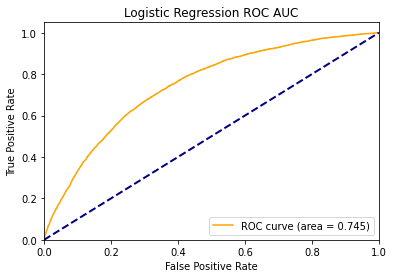

In [171]:
lr_qua_cat_rfe = make_log_reg(x_train=X_train_label.loc[:,rfecv.support_],
                               y_train=y_train,
                               x_valid=X_valid_label.loc[:,rfecv.support_],
                               y_valid=y_valid,
                               results_df=lr_metrics_cat,
                               model_name='lr_qua_cat_rfe')

In [172]:
lr_metrics_cat

,lr_baseline_cat,lr_qua_cat,lr_qua_cat_rfe
roc-auc,0.744886,0.744928,0.744899
precision,0.282262,0.281058,0.281800
recall,0.790763,0.796557,0.795067
f1,0.416024,0.415508,0.416114
logloss,13.496773,13.624586,13.565208


Попробуем провести отброс параметров еще раз, но в этот раз передадим в линейную регрессию большее число итераций.

In [173]:
lr_qua_cat_3 = LogisticRegression(class_weight='balanced',
                                  random_state=RND_STATE,
                                  max_iter=1000)

rfecv1 = RFECV(lr_qua_cat_3,
              scoring='roc_auc',
              n_jobs=-1,
              verbose=5)

In [174]:
rfecv1.fit(X_train_label.loc[:,rfecv.support_], y_train)

RFECV(estimator=LogisticRegression(class_weight='balanced', max_iter=1000,
                                   random_state=777),
      n_jobs=-1, scoring='roc_auc', verbose=5)

In [175]:
print(rfecv.n_features_)
print(X_train_label.loc[:,rfecv.support_].columns)

206
Index(['credit_month', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'age_sq', 'age_inv', 'credit_month_sq',
       'credit_month_inv', 'credit_count_sq', 'overdue_credit_count_sq',
       ...
       'score_shk_inv_cat_(-0.855, -0.854]_mul',
       'score_shk_inv_cat_(-0.763, 0.0871]_mul',
       'score_shk_inv_cat_(0.0871, 5.429]_mul',
       'payment_income_part_sq_cat_(-1.383, -0.532]_mul',
       'payment_income_part_sq_cat_(-0.532, -0.529]_mul',
       'payment_income_part_sq_cat_(0.691, 1.094]_mul',
       'payment_income_part_sq_cat_(1.094, 1.588]_mul',
       'payment_income_part_cat_(-0.415, -0.412]_mul',
       'payment_income_part_cat_(0.999, 1.531]_mul',
       'payment_income_part_cat_(1.531, 3.163]_mul'],
      dtype='object', length=206)


Можно заметить, что это не принесло результатов. Таким образом, можно взять на заметку, что отсеивание переменных можно проводить при низком количестве итераций оптимизатора.


###  Кривая заучивания
С помощью данной кривой оценим эффект влияния количества наблюдений в тренировочном наборе на метрический показатель roc-auc.

In [176]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(max_iter=1000),
                                        X_train_label.loc[:,rfecv.support_],
                                        y_train,
                                        cv=7,
                                        scoring='roc_auc',
                                        n_jobs=-1,
                                        train_sizes=np.linspace(0.01, 1.0, 40))

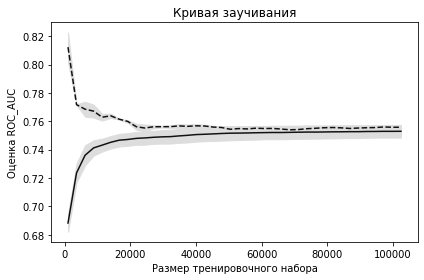

In [177]:
# Создать средние и стандартные отклонения оценок тренировочного набора
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Создать средние и стандартные отклонения оценок тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Нанести линии
plt.plot(train_sizes, train_mean, "--", color="#111111",
         label="Тренировочная оценка")
plt.plot(train_sizes, test_mean, color="#111111",
         label="Перекрестно-проверочная оценка")
# Нанести полосы
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="#DDDDDD")
# Построить график
plt.title("Кривая заучивания")
plt.xlabel("Размер тренировочного набора")
plt.ylabel("Оценка ROC_AUC")
plt.tight_layout()

**Отвечаем на вопрос - выиграют ли наши обучающиеся алгоритмы от сбора дополнительных тренировочных данных?**

In [178]:
! telegram-send 'learning_curve ready'

###  Эффект значений гиперпараметра
На данном этапе постараемся разобраться в том, как результативность модели изменяется по мере изменения значений некоторого гиперпараметра. Для этого построим график валидационной кривой.

In [179]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1', solver="liblinear"),
                                            X_train_label.loc[:,rfecv.support_],
                                            y_train,
                                            param_name='C',
                                            param_range=np.linspace(0.1, 10., 40),
                                            cv=3,
                                            scoring='roc_auc',
                                            n_jobs=-1)

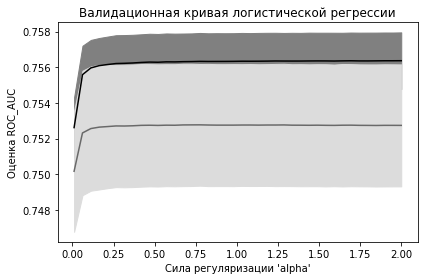

In [180]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Вычислить среднее и стандартное отклонение для оценок
# тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Построить график средних оценок точности
# для тренировочного и тестового наборов
plt.plot(np.linspace(0.01, 2.0, 40), train_mean, color="black",
         label="Тренировочная оценка")
plt.plot(np.linspace(0.01, 2.0, 40), test_mean, color="dimgrey",
         label="Перекрестно-проверочная оценка")

# Нанести полосы точности для тренировочного и тестового наборов
plt.fill_between(np.linspace(0.01, 2.0, 40), train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(np.linspace(0.01, 2.0, 40), test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

plt.title("Валидационная кривая логистической регрессии")
plt.xlabel("Сила регуляризации 'alpha'")
plt.ylabel("Оценка ROC_AUC")
plt.tight_layout()

In [181]:
! telegram-send 'validation_curve ready'

## Оптимизация модели с взаимодействием категорий и количественных переменных

In [182]:
parameters_grid = {
    'penalty': ['l1', 'l2' 'elasticnet'],
    'C': np.linspace(0.1, 2, num=5),
    'solver': ['sag', 'saga', 'lbfgs', 'liblinear'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(1000, 1500, 100)
}

In [183]:
!telegram-send "lr_qua_cat_1 optimization started!"

In [184]:
%%time
grid_cv_wcols_ncorr = find_optimal_params(x_train=X_train_label.loc[:,rfecv.support_],
                                          y_train=y_train,
                                          parameters_grid=parameters_grid)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


One or more of the test scores are non-finite: [       nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan        nan        nan        nan        nan 0.75225513
        nan 0.75221536        nan        nan        nan        nan
        nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan        nan        nan        nan        nan 0.75225513
        nan 0.75221536        nan        nan        nan        nan
        nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan        nan        nan        nan        nan 0.75225513
        nan 0.75221536        nan        nan        nan        nan
        nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan    

Наилучший ROC AUC = 0.7533
Наилучшие параметры: {'C': 2.0, 'l1_ratio': 0.2, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Wall time: 7h 44min 20s


In [185]:
!telegram-send "lr_qua_cat_1 optimization is over!"

In [188]:
best_params_qua_cat = grid_cv_wcols_ncorr.best_params_

In [ ]:
# best_params_qua_cat = {'C': 2.0,
#                        'l1_ratio': 0.2,
#                        'max_iter': 1000,
#                        'penalty': 'l1',
#                        'solver': 'saga'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


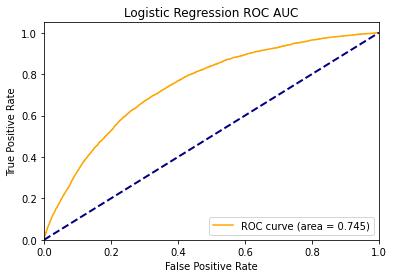

In [189]:
tuned_lr_qua_cat = make_log_reg(x_train=X_train_label.loc[:,rfecv.support_],
                                y_train=y_train,
                                x_valid=X_valid_label.loc[:,rfecv.support_],
                                y_valid=y_valid,
                                results_df=lr_metrics_cat,
                                parameters=best_params_qua_cat,
                                model_name='tuned_lr_qua_cat')

In [190]:
lr_metrics_cat.style.highlight_max(axis=1, color='lightblue')

,lr_baseline_cat,lr_qua_cat,lr_qua_cat_rfe,tuned_lr_qua_cat
roc-auc,0.744886,0.744928,0.744899,0.745277
precision,0.282262,0.281058,0.281800,0.285030
recall,0.790763,0.796557,0.795067,0.787949
f1,0.416024,0.415508,0.416114,0.418627
logloss,13.496773,13.624586,13.565208,13.305557


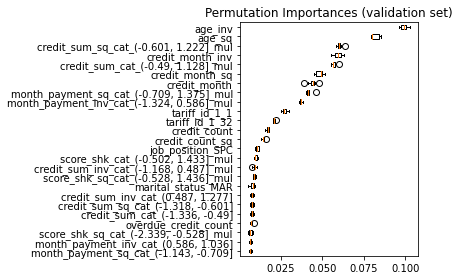

In [191]:
perm_imp_test = permutation_importance(tuned_lr_qua_cat,
                                       X_valid_label.loc[:,rfecv.support_],
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_valid_label.loc[:,rfecv.support_].columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()